In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from pprint import pprint

from toolbox  import detach, flatten, tensor
from unidimensional import UnidimensionalGUM as GUM,\
                           UnidimensionalHMM as HMM,\
                           UnidimensionalRNN as RNN
from unidimensional import get_GUM_from_AB, sample_AB
from training import ABTrainingVisitor,               \
                     AggregateTrainingVisitor,        \
                     DefaultTrainingVisitor,          \
                     LossTrainingVisitor,             \
                     TalkativeTrainingVisitor,        \
                     parameters_estimation

# Unknown GUM

In [2]:
unknown_gum = GUM(
    a      = tensor([[.3]]),
    b      = tensor([[.9]]),
    c      = tensor([[.1]]),
    eta_   = flatten(tensor([[.7]])),
)

print(unknown_gum)

Parameters:
	> a     : tensor([[0.3000]])
	> b     : tensor([[0.9000]])
	> c     : tensor([[0.1000]])
	> eta   : tensor([[0.7000]])
	> alpha : tensor([[0.5892]])
	> beta  : tensor([[0.4330]])
A=tensor([[0.3900]]), B=tensor([[0.2601]])


## Observations generation

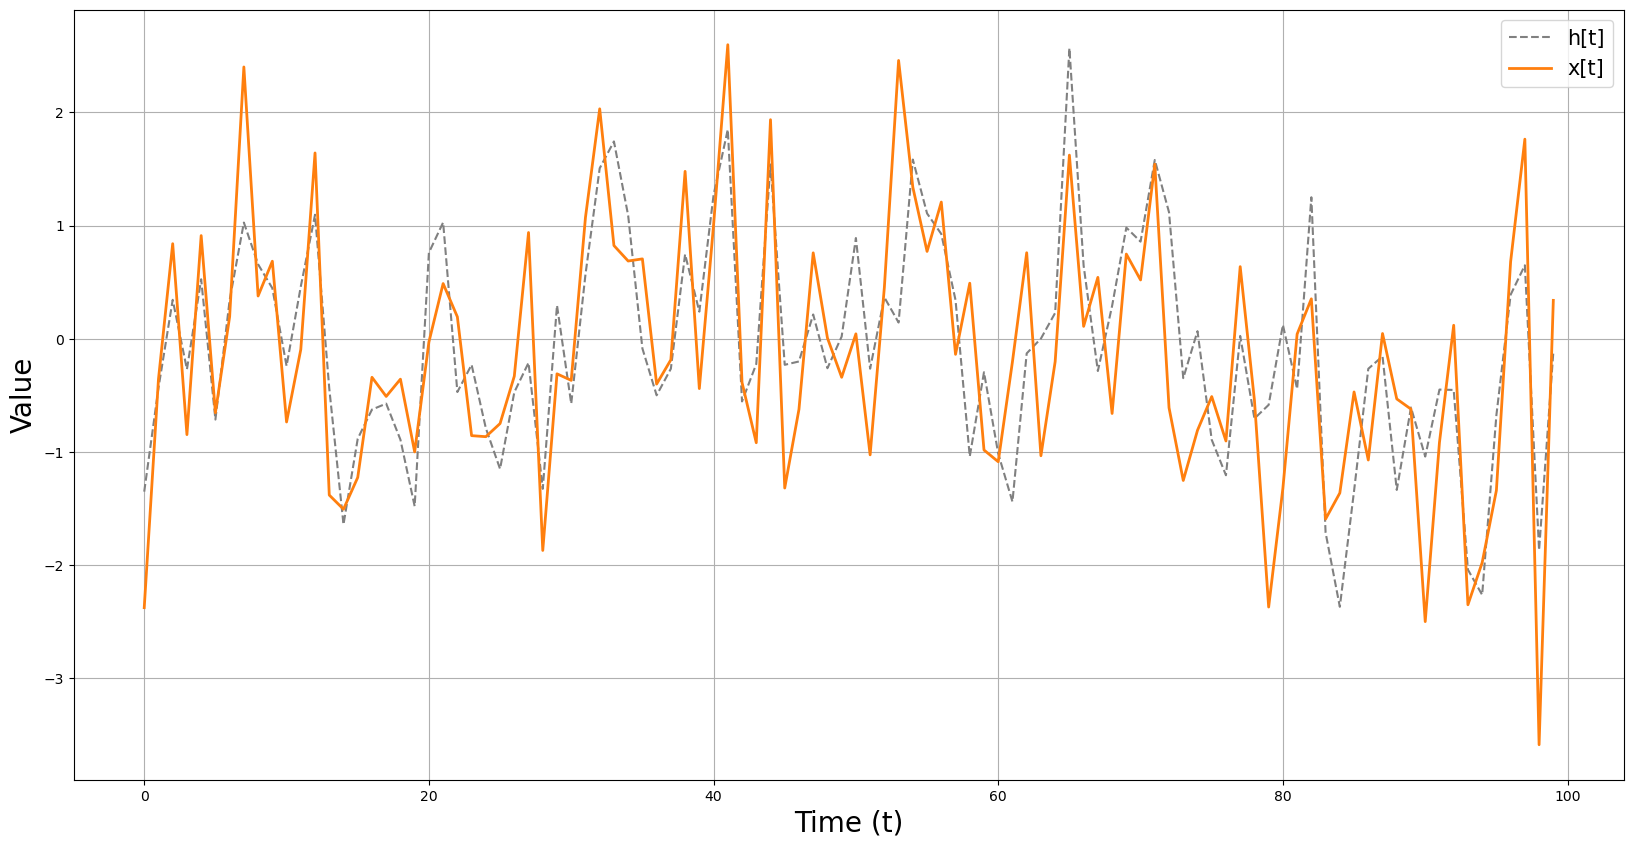

Mean: tensor([-0.1496]) ; Variance: tensor([1.3113])


In [3]:
# Sample
h, x = unknown_gum.sample(100)

# Plot
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('xkcd:white')

plt.plot(list(map(lambda h: h.numpy().ravel(), h)), color="grey", linestyle="dashed", label="h[t]")
plt.plot(list(map(lambda x: x.numpy().ravel(), x)), color="C1", label="x[t]", linewidth=2)
plt.legend(fontsize=15)
plt.xlabel("Time (t)", fontsize=20)
plt.ylabel("Value"   , fontsize=20)
plt.grid()
plt.show()

print("Mean:", torch.mean(torch.cat(x, dim=0), dim=0), "; Variance:", torch.var(torch.cat(x, dim=0), dim=0))

## Derivation of the likelihood

In [4]:
# the generated suite of observation by the model itself
print("Negative log-likelihood of generated observations : {0}".format(
    detach(unknown_gum.negative_log_likelihood(x))))

# an unlikely suite (constant, equal to 42)
print("Negative log-likelihood of a constant serie       : {0}".format(
    detach(unknown_gum.negative_log_likelihood([tensor([[42]]) for _ in range(len(x))]))))

Negative log-likelihood of generated observations : 1.5800213813781738
Negative log-likelihood of a constant serie       : 484.1977233886719


In [5]:
l = []
for _ in range(100):
    h, x = unknown_gum.sample(1000)
    l.append(unknown_gum.negative_log_likelihood(x).numpy()[0, 0])
    
print("Average loss: {0}; Std: {1}".format(np.mean(l), np.std(l)))

Average loss: 1.385165810585022; Std: 0.024082845076918602


In [6]:
h, x = unknown_gum.sample(1000)

X = []

n = 100
for i in range(0, n+1):
    X.append([])
    
    B = -(i/n * 2 - 1)
    for j in range(0, n+1):
        A = (j/n * 2 - 1)
        
        if (A-1)/2 <= B and B <= (A+1)/2:
            gum = get_GUM_from_AB(A, B)
        
            X[-1].append(gum.negative_log_likelihood(x).numpy()[0, 0])
        else:
            X[-1].append(0)

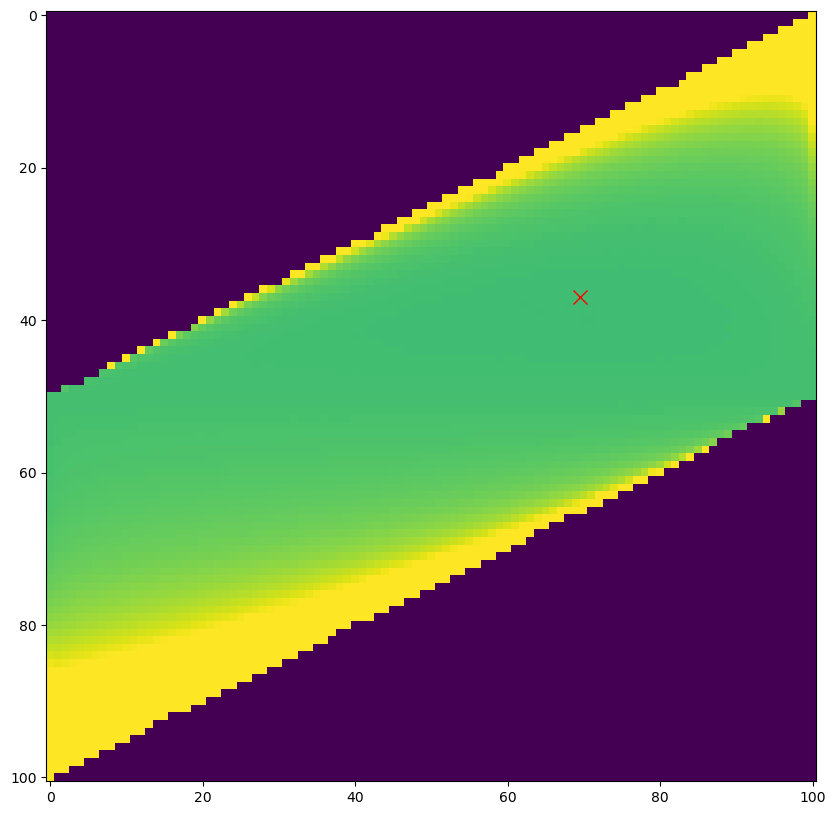

In [7]:
bound=2
X_ = np.minimum(np.array(X), bound*np.ones(np.shape(X)))

fig = plt.figure(figsize=(10, 10)) 
fig.patch.set_facecolor('xkcd:white')
ax  = fig.add_subplot(111, aspect='equal')

plt.imshow(X_)
ax.plot(
    [(1 + unknown_gum.A.detach().numpy()[0, 0]) * n/2 ], 
    [-(unknown_gum.B.detach().numpy()[0, 0] - 1) * n/2  ],
    marker="x", markersize=10, label="Unknown generator", color="red", linestyle="None"
)
plt.show()

In [23]:
np.min(X_[np.nonzero(X_)])

1.3821148872375488

# Parameters estimation

In [8]:
A, B = sample_AB()
print("Starting from (A={0}, B={1}).\n".format(A, B))

gum = get_GUM_from_AB(A, B, requires_grad=True)

gum = GUM(
    a      = tensor([[.1]]),
    b      = tensor([[.9]]),
    c      = tensor([[.7]]),
    eta_   = tensor([[.3]]),
    requires_grad=True
)

# gum = HMM(
#     a      = tensor([[.1]]),
#     b      = tensor([[.9]]),
#     eta_   = tensor([[.7]]),
#     requires_grad=True
# )

# gum = RNN(
#     a      = tensor([[.1]]),
#     b      = tensor([[.9]]),
#     c      = tensor([[.7]]),
#     requires_grad=True
# )

print(gum)

Starting from (A=-0.3592488636516451, B=-0.6741789922303709).

Parameters:
	> a     : tensor([[0.1000]], requires_grad=True)
	> b     : tensor([[0.9000]], requires_grad=True)
	> c     : tensor([[0.7000]], requires_grad=True)
	> eta   : tensor([[0.3000]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2308]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7570]], grad_fn=<RsubBackward1>)
A=tensor([[0.7300]]), B=tensor([[0.6543]])


In [6]:
print("RNN: expected B={0}, computed B={1}".format(gum.A * (2 * gum.A**2 - 1), gum.B))

RNN: expected B=tensor([[-0.0980]]), computed B=tensor([[0.0567]])


In [9]:
loss_visitor = LossTrainingVisitor()
AB_visitor   = ABTrainingVisitor()

optimizer        = torch.optim.Adam(gum.theta, lr=.001)

def _lr_(epoch, decays=[]):
    if epoch < len(decays):
        return decays[epoch]
    else:
        return 1

scheduler        = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[.5, .2]))

gum = parameters_estimation(
    gum, 
    unknown_gum, 
    n_observations = 1000, 
    n_epochs       = 3, 
    size_batch     = 1000,     
    optimizer      = optimizer,
    scheduler      = scheduler,
    visitor        = AggregateTrainingVisitor([
        AB_visitor,
        loss_visitor, 
        TalkativeTrainingVisitor()
    ])
)

> Iteration 1/3000
Parameters:
	> a     : tensor([[0.0995]], requires_grad=True)
	> b     : tensor([[0.8995]], requires_grad=True)
	> c     : tensor([[0.6995]], requires_grad=True)
	> eta   : tensor([[0.2995]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2303]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7577]], grad_fn=<RsubBackward1>)
A=tensor([[0.7287]]), B=tensor([[0.6533]])
Loss: 1.5168919563293457

> Iteration 2/3000
Parameters:
	> a     : tensor([[0.0990]], requires_grad=True)
	> b     : tensor([[0.8990]], requires_grad=True)
	> c     : tensor([[0.6990]], requires_grad=True)
	> eta   : tensor([[0.2990]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2297]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7583]], grad_fn=<RsubBackward1>)
A=tensor([[0.7274]]), B=tensor([[0.6523]])
Loss: 1.6316419839859009

> Iteration 3/3000
Parameters:
	> a     : tensor([[0.0985]], requires_grad=True)
	> b     : tensor([[0.8985]], requires_grad=True)
	> c     : tensor([[0.6985]], requires_grad=T

> Iteration 21/3000
Parameters:
	> a     : tensor([[0.0898]], requires_grad=True)
	> b     : tensor([[0.8896]], requires_grad=True)
	> c     : tensor([[0.6896]], requires_grad=True)
	> eta   : tensor([[0.2897]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2201]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7707]], grad_fn=<RsubBackward1>)
A=tensor([[0.7033]]), B=tensor([[0.6341]])
Loss: 1.560874104499817

> Iteration 22/3000
Parameters:
	> a     : tensor([[0.0893]], requires_grad=True)
	> b     : tensor([[0.8892]], requires_grad=True)
	> c     : tensor([[0.6892]], requires_grad=True)
	> eta   : tensor([[0.2893]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2197]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7713]], grad_fn=<RsubBackward1>)
A=tensor([[0.7021]]), B=tensor([[0.6332]])
Loss: 1.5036693811416626

> Iteration 23/3000
Parameters:
	> a     : tensor([[0.0888]], requires_grad=True)
	> b     : tensor([[0.8887]], requires_grad=True)
	> c     : tensor([[0.6887]], requires_grad

> Iteration 41/3000
Parameters:
	> a     : tensor([[0.0809]], requires_grad=True)
	> b     : tensor([[0.8803]], requires_grad=True)
	> c     : tensor([[0.6802]], requires_grad=True)
	> eta   : tensor([[0.2807]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2110]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7825]], grad_fn=<RsubBackward1>)
A=tensor([[0.6796]]), B=tensor([[0.6163]])
Loss: 1.4862509965896606

> Iteration 42/3000
Parameters:
	> a     : tensor([[0.0805]], requires_grad=True)
	> b     : tensor([[0.8798]], requires_grad=True)
	> c     : tensor([[0.6797]], requires_grad=True)
	> eta   : tensor([[0.2803]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2105]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7830]], grad_fn=<RsubBackward1>)
A=tensor([[0.6785]]), B=tensor([[0.6155]])
Loss: 1.5617940425872803

> Iteration 43/3000
Parameters:
	> a     : tensor([[0.0801]], requires_grad=True)
	> b     : tensor([[0.8793]], requires_grad=True)
	> c     : tensor([[0.6793]], requires_gra

> Iteration 61/3000
Parameters:
	> a     : tensor([[0.0733]], requires_grad=True)
	> b     : tensor([[0.8714]], requires_grad=True)
	> c     : tensor([[0.6713]], requires_grad=True)
	> eta   : tensor([[0.2727]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2027]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7929]], grad_fn=<RsubBackward1>)
A=tensor([[0.6582]]), B=tensor([[0.6001]])
Loss: 1.566809892654419

> Iteration 62/3000
Parameters:
	> a     : tensor([[0.0729]], requires_grad=True)
	> b     : tensor([[0.8710]], requires_grad=True)
	> c     : tensor([[0.6708]], requires_grad=True)
	> eta   : tensor([[0.2723]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.2024]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.7934]], grad_fn=<RsubBackward1>)
A=tensor([[0.6572]]), B=tensor([[0.5994]])
Loss: 1.5016340017318726

> Iteration 63/3000
Parameters:
	> a     : tensor([[0.0726]], requires_grad=True)
	> b     : tensor([[0.8706]], requires_grad=True)
	> c     : tensor([[0.6704]], requires_grad

> Iteration 81/3000
Parameters:
	> a     : tensor([[0.0666]], requires_grad=True)
	> b     : tensor([[0.8633]], requires_grad=True)
	> c     : tensor([[0.6630]], requires_grad=True)
	> eta   : tensor([[0.2658]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1953]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8019]], grad_fn=<RsubBackward1>)
A=tensor([[0.6390]]), B=tensor([[0.5856]])
Loss: 1.5234699249267578

> Iteration 82/3000
Parameters:
	> a     : tensor([[0.0663]], requires_grad=True)
	> b     : tensor([[0.8629]], requires_grad=True)
	> c     : tensor([[0.6626]], requires_grad=True)
	> eta   : tensor([[0.2654]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1949]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8024]], grad_fn=<RsubBackward1>)
A=tensor([[0.6381]]), B=tensor([[0.5849]])
Loss: 1.4595305919647217

> Iteration 83/3000
Parameters:
	> a     : tensor([[0.0660]], requires_grad=True)
	> b     : tensor([[0.8625]], requires_grad=True)
	> c     : tensor([[0.6622]], requires_gra

> Iteration 101/3000
Parameters:
	> a     : tensor([[0.0612]], requires_grad=True)
	> b     : tensor([[0.8556]], requires_grad=True)
	> c     : tensor([[0.6551]], requires_grad=True)
	> eta   : tensor([[0.2595]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1885]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8101]], grad_fn=<RsubBackward1>)
A=tensor([[0.6217]]), B=tensor([[0.5721]])
Loss: 1.4820797443389893

> Iteration 102/3000
Parameters:
	> a     : tensor([[0.0609]], requires_grad=True)
	> b     : tensor([[0.8552]], requires_grad=True)
	> c     : tensor([[0.6547]], requires_grad=True)
	> eta   : tensor([[0.2592]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1881]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8104]], grad_fn=<RsubBackward1>)
A=tensor([[0.6208]]), B=tensor([[0.5715]])
Loss: 1.4677373170852661

> Iteration 103/3000
Parameters:
	> a     : tensor([[0.0606]], requires_grad=True)
	> b     : tensor([[0.8548]], requires_grad=True)
	> c     : tensor([[0.6544]], requires_

> Iteration 121/3000
Parameters:
	> a     : tensor([[0.0557]], requires_grad=True)
	> b     : tensor([[0.8485]], requires_grad=True)
	> c     : tensor([[0.6479]], requires_grad=True)
	> eta   : tensor([[0.2542]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1819]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8169]], grad_fn=<RsubBackward1>)
A=tensor([[0.6054]]), B=tensor([[0.5599]])
Loss: 1.498649001121521

> Iteration 122/3000
Parameters:
	> a     : tensor([[0.0554]], requires_grad=True)
	> b     : tensor([[0.8482]], requires_grad=True)
	> c     : tensor([[0.6475]], requires_grad=True)
	> eta   : tensor([[0.2540]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1815]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8173]], grad_fn=<RsubBackward1>)
A=tensor([[0.6046]]), B=tensor([[0.5593]])
Loss: 1.49861741065979

> Iteration 123/3000
Parameters:
	> a     : tensor([[0.0551]], requires_grad=True)
	> b     : tensor([[0.8478]], requires_grad=True)
	> c     : tensor([[0.6472]], requires_gra

> Iteration 141/3000
Parameters:
	> a     : tensor([[0.0506]], requires_grad=True)
	> b     : tensor([[0.8417]], requires_grad=True)
	> c     : tensor([[0.6409]], requires_grad=True)
	> eta   : tensor([[0.2495]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1754]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8232]], grad_fn=<RsubBackward1>)
A=tensor([[0.5901]]), B=tensor([[0.5484]])
Loss: 1.4975284337997437

> Iteration 142/3000
Parameters:
	> a     : tensor([[0.0504]], requires_grad=True)
	> b     : tensor([[0.8414]], requires_grad=True)
	> c     : tensor([[0.6405]], requires_grad=True)
	> eta   : tensor([[0.2493]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1751]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8235]], grad_fn=<RsubBackward1>)
A=tensor([[0.5894]]), B=tensor([[0.5478]])
Loss: 1.4341199398040771

> Iteration 143/3000
Parameters:
	> a     : tensor([[0.0502]], requires_grad=True)
	> b     : tensor([[0.8411]], requires_grad=True)
	> c     : tensor([[0.6402]], requires_

> Iteration 161/3000
Parameters:
	> a     : tensor([[0.0469]], requires_grad=True)
	> b     : tensor([[0.8352]], requires_grad=True)
	> c     : tensor([[0.6341]], requires_grad=True)
	> eta   : tensor([[0.2453]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1695]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8289]], grad_fn=<RsubBackward1>)
A=tensor([[0.5765]]), B=tensor([[0.5376]])
Loss: 1.4952751398086548

> Iteration 162/3000
Parameters:
	> a     : tensor([[0.0468]], requires_grad=True)
	> b     : tensor([[0.8349]], requires_grad=True)
	> c     : tensor([[0.6337]], requires_grad=True)
	> eta   : tensor([[0.2451]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1692]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8292]], grad_fn=<RsubBackward1>)
A=tensor([[0.5758]]), B=tensor([[0.5371]])
Loss: 1.4313408136367798

> Iteration 163/3000
Parameters:
	> a     : tensor([[0.0466]], requires_grad=True)
	> b     : tensor([[0.8345]], requires_grad=True)
	> c     : tensor([[0.6334]], requires_

> Iteration 181/3000
Parameters:
	> a     : tensor([[0.0438]], requires_grad=True)
	> b     : tensor([[0.8288]], requires_grad=True)
	> c     : tensor([[0.6274]], requires_grad=True)
	> eta   : tensor([[0.2413]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1638]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8342]], grad_fn=<RsubBackward1>)
A=tensor([[0.5638]]), B=tensor([[0.5273]])
Loss: 1.443163275718689

> Iteration 182/3000
Parameters:
	> a     : tensor([[0.0437]], requires_grad=True)
	> b     : tensor([[0.8285]], requires_grad=True)
	> c     : tensor([[0.6271]], requires_grad=True)
	> eta   : tensor([[0.2411]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1635]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8345]], grad_fn=<RsubBackward1>)
A=tensor([[0.5632]]), B=tensor([[0.5268]])
Loss: 1.4322954416275024

> Iteration 183/3000
Parameters:
	> a     : tensor([[0.0435]], requires_grad=True)
	> b     : tensor([[0.8282]], requires_grad=True)
	> c     : tensor([[0.6268]], requires_g

> Iteration 201/3000
Parameters:
	> a     : tensor([[0.0404]], requires_grad=True)
	> b     : tensor([[0.8229]], requires_grad=True)
	> c     : tensor([[0.6212]], requires_grad=True)
	> eta   : tensor([[0.2379]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1582]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8389]], grad_fn=<RsubBackward1>)
A=tensor([[0.5516]]), B=tensor([[0.5177]])
Loss: 1.4488624334335327

> Iteration 202/3000
Parameters:
	> a     : tensor([[0.0403]], requires_grad=True)
	> b     : tensor([[0.8226]], requires_grad=True)
	> c     : tensor([[0.6209]], requires_grad=True)
	> eta   : tensor([[0.2378]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1580]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8391]], grad_fn=<RsubBackward1>)
A=tensor([[0.5510]]), B=tensor([[0.5173]])
Loss: 1.3882840871810913

> Iteration 203/3000
Parameters:
	> a     : tensor([[0.0401]], requires_grad=True)
	> b     : tensor([[0.8223]], requires_grad=True)
	> c     : tensor([[0.6206]], requires_

> Iteration 221/3000
Parameters:
	> a     : tensor([[0.0377]], requires_grad=True)
	> b     : tensor([[0.8173]], requires_grad=True)
	> c     : tensor([[0.6154]], requires_grad=True)
	> eta   : tensor([[0.2349]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1531]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8431]], grad_fn=<RsubBackward1>)
A=tensor([[0.5407]]), B=tensor([[0.5089]])
Loss: 1.5668500661849976

> Iteration 222/3000
Parameters:
	> a     : tensor([[0.0375]], requires_grad=True)
	> b     : tensor([[0.8170]], requires_grad=True)
	> c     : tensor([[0.6151]], requires_grad=True)
	> eta   : tensor([[0.2348]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1528]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8433]], grad_fn=<RsubBackward1>)
A=tensor([[0.5401]]), B=tensor([[0.5085]])
Loss: 1.4250531196594238

> Iteration 223/3000
Parameters:
	> a     : tensor([[0.0374]], requires_grad=True)
	> b     : tensor([[0.8168]], requires_grad=True)
	> c     : tensor([[0.6148]], requires_

> Iteration 241/3000
Parameters:
	> a     : tensor([[0.0353]], requires_grad=True)
	> b     : tensor([[0.8119]], requires_grad=True)
	> c     : tensor([[0.6097]], requires_grad=True)
	> eta   : tensor([[0.2322]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1480]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8470]], grad_fn=<RsubBackward1>)
A=tensor([[0.5303]]), B=tensor([[0.5004]])
Loss: 1.469541311264038

> Iteration 242/3000
Parameters:
	> a     : tensor([[0.0352]], requires_grad=True)
	> b     : tensor([[0.8116]], requires_grad=True)
	> c     : tensor([[0.6094]], requires_grad=True)
	> eta   : tensor([[0.2320]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1477]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8472]], grad_fn=<RsubBackward1>)
A=tensor([[0.5298]]), B=tensor([[0.5000]])
Loss: 1.44517982006073

> Iteration 243/3000
Parameters:
	> a     : tensor([[0.0351]], requires_grad=True)
	> b     : tensor([[0.8113]], requires_grad=True)
	> c     : tensor([[0.6091]], requires_gra

> Iteration 261/3000
Parameters:
	> a     : tensor([[0.0334]], requires_grad=True)
	> b     : tensor([[0.8066]], requires_grad=True)
	> c     : tensor([[0.6041]], requires_grad=True)
	> eta   : tensor([[0.2296]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1431]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8506]], grad_fn=<RsubBackward1>)
A=tensor([[0.5207]]), B=tensor([[0.4923]])
Loss: 1.4046071767807007

> Iteration 262/3000
Parameters:
	> a     : tensor([[0.0333]], requires_grad=True)
	> b     : tensor([[0.8063]], requires_grad=True)
	> c     : tensor([[0.6038]], requires_grad=True)
	> eta   : tensor([[0.2295]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1428]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8508]], grad_fn=<RsubBackward1>)
A=tensor([[0.5202]]), B=tensor([[0.4919]])
Loss: 1.4459832906723022

> Iteration 263/3000
Parameters:
	> a     : tensor([[0.0332]], requires_grad=True)
	> b     : tensor([[0.8061]], requires_grad=True)
	> c     : tensor([[0.6036]], requires_

> Iteration 281/3000
Parameters:
	> a     : tensor([[0.0314]], requires_grad=True)
	> b     : tensor([[0.8016]], requires_grad=True)
	> c     : tensor([[0.5988]], requires_grad=True)
	> eta   : tensor([[0.2273]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1383]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8539]], grad_fn=<RsubBackward1>)
A=tensor([[0.5114]]), B=tensor([[0.4846]])
Loss: 1.464805006980896

> Iteration 282/3000
Parameters:
	> a     : tensor([[0.0313]], requires_grad=True)
	> b     : tensor([[0.8013]], requires_grad=True)
	> c     : tensor([[0.5986]], requires_grad=True)
	> eta   : tensor([[0.2272]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1381]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8541]], grad_fn=<RsubBackward1>)
A=tensor([[0.5109]]), B=tensor([[0.4842]])
Loss: 1.4093172550201416

> Iteration 283/3000
Parameters:
	> a     : tensor([[0.0312]], requires_grad=True)
	> b     : tensor([[0.8011]], requires_grad=True)
	> c     : tensor([[0.5983]], requires_g

> Iteration 301/3000
Parameters:
	> a     : tensor([[0.0299]], requires_grad=True)
	> b     : tensor([[0.7968]], requires_grad=True)
	> c     : tensor([[0.5937]], requires_grad=True)
	> eta   : tensor([[0.2252]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1338]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8570]], grad_fn=<RsubBackward1>)
A=tensor([[0.5030]]), B=tensor([[0.4774]])
Loss: 1.4193485975265503

> Iteration 302/3000
Parameters:
	> a     : tensor([[0.0298]], requires_grad=True)
	> b     : tensor([[0.7966]], requires_grad=True)
	> c     : tensor([[0.5935]], requires_grad=True)
	> eta   : tensor([[0.2251]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1336]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8571]], grad_fn=<RsubBackward1>)
A=tensor([[0.5026]]), B=tensor([[0.4770]])
Loss: 1.4372851848602295

> Iteration 303/3000
Parameters:
	> a     : tensor([[0.0298]], requires_grad=True)
	> b     : tensor([[0.7963]], requires_grad=True)
	> c     : tensor([[0.5932]], requires_

> Iteration 321/3000
Parameters:
	> a     : tensor([[0.0287]], requires_grad=True)
	> b     : tensor([[0.7922]], requires_grad=True)
	> c     : tensor([[0.5889]], requires_grad=True)
	> eta   : tensor([[0.2233]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1296]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8598]], grad_fn=<RsubBackward1>)
A=tensor([[0.4952]]), B=tensor([[0.4705]])
Loss: 1.4375267028808594

> Iteration 322/3000
Parameters:
	> a     : tensor([[0.0286]], requires_grad=True)
	> b     : tensor([[0.7920]], requires_grad=True)
	> c     : tensor([[0.5886]], requires_grad=True)
	> eta   : tensor([[0.2233]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1294]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8600]], grad_fn=<RsubBackward1>)
A=tensor([[0.4948]]), B=tensor([[0.4702]])
Loss: 1.4064656496047974

> Iteration 323/3000
Parameters:
	> a     : tensor([[0.0285]], requires_grad=True)
	> b     : tensor([[0.7918]], requires_grad=True)
	> c     : tensor([[0.5884]], requires_

> Iteration 341/3000
Parameters:
	> a     : tensor([[0.0268]], requires_grad=True)
	> b     : tensor([[0.7875]], requires_grad=True)
	> c     : tensor([[0.5839]], requires_grad=True)
	> eta   : tensor([[0.2215]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1250]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8626]], grad_fn=<RsubBackward1>)
A=tensor([[0.4867]]), B=tensor([[0.4635]])
Loss: 1.4081881046295166

> Iteration 342/3000
Parameters:
	> a     : tensor([[0.0267]], requires_grad=True)
	> b     : tensor([[0.7873]], requires_grad=True)
	> c     : tensor([[0.5836]], requires_grad=True)
	> eta   : tensor([[0.2214]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1248]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8628]], grad_fn=<RsubBackward1>)
A=tensor([[0.4862]]), B=tensor([[0.4632]])
Loss: 1.4343558549880981

> Iteration 343/3000
Parameters:
	> a     : tensor([[0.0266]], requires_grad=True)
	> b     : tensor([[0.7871]], requires_grad=True)
	> c     : tensor([[0.5834]], requires_

> Iteration 361/3000
Parameters:
	> a     : tensor([[0.0247]], requires_grad=True)
	> b     : tensor([[0.7830]], requires_grad=True)
	> c     : tensor([[0.5791]], requires_grad=True)
	> eta   : tensor([[0.2199]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1205]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8652]], grad_fn=<RsubBackward1>)
A=tensor([[0.4782]]), B=tensor([[0.4568]])
Loss: 1.428202748298645

> Iteration 362/3000
Parameters:
	> a     : tensor([[0.0246]], requires_grad=True)
	> b     : tensor([[0.7828]], requires_grad=True)
	> c     : tensor([[0.5788]], requires_grad=True)
	> eta   : tensor([[0.2198]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1203]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8653]], grad_fn=<RsubBackward1>)
A=tensor([[0.4778]]), B=tensor([[0.4564]])
Loss: 1.4204776287078857

> Iteration 363/3000
Parameters:
	> a     : tensor([[0.0245]], requires_grad=True)
	> b     : tensor([[0.7826]], requires_grad=True)
	> c     : tensor([[0.5786]], requires_g

> Iteration 381/3000
Parameters:
	> a     : tensor([[0.0231]], requires_grad=True)
	> b     : tensor([[0.7789]], requires_grad=True)
	> c     : tensor([[0.5746]], requires_grad=True)
	> eta   : tensor([[0.2185]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1163]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8675]], grad_fn=<RsubBackward1>)
A=tensor([[0.4706]]), B=tensor([[0.4506]])
Loss: 1.428080439567566

> Iteration 382/3000
Parameters:
	> a     : tensor([[0.0230]], requires_grad=True)
	> b     : tensor([[0.7786]], requires_grad=True)
	> c     : tensor([[0.5744]], requires_grad=True)
	> eta   : tensor([[0.2184]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1161]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8676]], grad_fn=<RsubBackward1>)
A=tensor([[0.4703]]), B=tensor([[0.4503]])
Loss: 1.3925584554672241

> Iteration 383/3000
Parameters:
	> a     : tensor([[0.0229]], requires_grad=True)
	> b     : tensor([[0.7784]], requires_grad=True)
	> c     : tensor([[0.5741]], requires_g

> Iteration 401/3000
Parameters:
	> a     : tensor([[0.0214]], requires_grad=True)
	> b     : tensor([[0.7748]], requires_grad=True)
	> c     : tensor([[0.5702]], requires_grad=True)
	> eta   : tensor([[0.2172]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1122]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8696]], grad_fn=<RsubBackward1>)
A=tensor([[0.4631]]), B=tensor([[0.4446]])
Loss: 1.4152566194534302

> Iteration 402/3000
Parameters:
	> a     : tensor([[0.0213]], requires_grad=True)
	> b     : tensor([[0.7746]], requires_grad=True)
	> c     : tensor([[0.5700]], requires_grad=True)
	> eta   : tensor([[0.2171]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1119]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8697]], grad_fn=<RsubBackward1>)
A=tensor([[0.4628]]), B=tensor([[0.4443]])
Loss: 1.4014652967453003

> Iteration 403/3000
Parameters:
	> a     : tensor([[0.0212]], requires_grad=True)
	> b     : tensor([[0.7744]], requires_grad=True)
	> c     : tensor([[0.5698]], requires_

> Iteration 421/3000
Parameters:
	> a     : tensor([[0.0203]], requires_grad=True)
	> b     : tensor([[0.7709]], requires_grad=True)
	> c     : tensor([[0.5660]], requires_grad=True)
	> eta   : tensor([[0.2160]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1083]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8716]], grad_fn=<RsubBackward1>)
A=tensor([[0.4566]]), B=tensor([[0.4389]])
Loss: 1.3747360706329346

> Iteration 422/3000
Parameters:
	> a     : tensor([[0.0202]], requires_grad=True)
	> b     : tensor([[0.7707]], requires_grad=True)
	> c     : tensor([[0.5658]], requires_grad=True)
	> eta   : tensor([[0.2159]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1081]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8717]], grad_fn=<RsubBackward1>)
A=tensor([[0.4563]]), B=tensor([[0.4387]])
Loss: 1.3867710828781128

> Iteration 423/3000
Parameters:
	> a     : tensor([[0.0202]], requires_grad=True)
	> b     : tensor([[0.7705]], requires_grad=True)
	> c     : tensor([[0.5656]], requires_

> Iteration 441/3000
Parameters:
	> a     : tensor([[0.0188]], requires_grad=True)
	> b     : tensor([[0.7672]], requires_grad=True)
	> c     : tensor([[0.5620]], requires_grad=True)
	> eta   : tensor([[0.2150]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1044]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8735]], grad_fn=<RsubBackward1>)
A=tensor([[0.4499]]), B=tensor([[0.4335]])
Loss: 1.430668592453003

> Iteration 442/3000
Parameters:
	> a     : tensor([[0.0187]], requires_grad=True)
	> b     : tensor([[0.7670]], requires_grad=True)
	> c     : tensor([[0.5618]], requires_grad=True)
	> eta   : tensor([[0.2149]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1042]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8736]], grad_fn=<RsubBackward1>)
A=tensor([[0.4496]]), B=tensor([[0.4332]])
Loss: 1.406990647315979

> Iteration 443/3000
Parameters:
	> a     : tensor([[0.0186]], requires_grad=True)
	> b     : tensor([[0.7668]], requires_grad=True)
	> c     : tensor([[0.5615]], requires_gr

> Iteration 461/3000
Parameters:
	> a     : tensor([[0.0176]], requires_grad=True)
	> b     : tensor([[0.7631]], requires_grad=True)
	> c     : tensor([[0.5576]], requires_grad=True)
	> eta   : tensor([[0.2139]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1003]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8754]], grad_fn=<RsubBackward1>)
A=tensor([[0.4431]]), B=tensor([[0.4277]])
Loss: 1.4243505001068115

> Iteration 462/3000
Parameters:
	> a     : tensor([[0.0175]], requires_grad=True)
	> b     : tensor([[0.7629]], requires_grad=True)
	> c     : tensor([[0.5574]], requires_grad=True)
	> eta   : tensor([[0.2139]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.1001]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8755]], grad_fn=<RsubBackward1>)
A=tensor([[0.4428]]), B=tensor([[0.4274]])
Loss: 1.4310933351516724

> Iteration 463/3000
Parameters:
	> a     : tensor([[0.0175]], requires_grad=True)
	> b     : tensor([[0.7627]], requires_grad=True)
	> c     : tensor([[0.5572]], requires_

> Iteration 481/3000
Parameters:
	> a     : tensor([[0.0163]], requires_grad=True)
	> b     : tensor([[0.7594]], requires_grad=True)
	> c     : tensor([[0.5536]], requires_grad=True)
	> eta   : tensor([[0.2130]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0964]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8771]], grad_fn=<RsubBackward1>)
A=tensor([[0.4368]]), B=tensor([[0.4224]])
Loss: 1.4297559261322021

> Iteration 482/3000
Parameters:
	> a     : tensor([[0.0163]], requires_grad=True)
	> b     : tensor([[0.7593]], requires_grad=True)
	> c     : tensor([[0.5534]], requires_grad=True)
	> eta   : tensor([[0.2130]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0962]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8772]], grad_fn=<RsubBackward1>)
A=tensor([[0.4364]]), B=tensor([[0.4222]])
Loss: 1.4027162790298462

> Iteration 483/3000
Parameters:
	> a     : tensor([[0.0162]], requires_grad=True)
	> b     : tensor([[0.7591]], requires_grad=True)
	> c     : tensor([[0.5532]], requires_

> Iteration 501/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7560]], requires_grad=True)
	> c     : tensor([[0.5498]], requires_grad=True)
	> eta   : tensor([[0.2122]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0929]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8787]], grad_fn=<RsubBackward1>)
A=tensor([[0.4314]]), B=tensor([[0.4176]])
Loss: 1.4033117294311523

> Iteration 502/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7558]], requires_grad=True)
	> c     : tensor([[0.5496]], requires_grad=True)
	> eta   : tensor([[0.2122]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0928]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8788]], grad_fn=<RsubBackward1>)
A=tensor([[0.4312]]), B=tensor([[0.4173]])
Loss: 1.4117668867111206

> Iteration 503/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7557]], requires_grad=True)
	> c     : tensor([[0.5495]], requires_

> Iteration 521/3000
Parameters:
	> a     : tensor([[0.0154]], requires_grad=True)
	> b     : tensor([[0.7526]], requires_grad=True)
	> c     : tensor([[0.5461]], requires_grad=True)
	> eta   : tensor([[0.2115]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0895]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8802]], grad_fn=<RsubBackward1>)
A=tensor([[0.4264]]), B=tensor([[0.4129]])
Loss: 1.3838095664978027

> Iteration 522/3000
Parameters:
	> a     : tensor([[0.0153]], requires_grad=True)
	> b     : tensor([[0.7524]], requires_grad=True)
	> c     : tensor([[0.5460]], requires_grad=True)
	> eta   : tensor([[0.2114]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0894]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8803]], grad_fn=<RsubBackward1>)
A=tensor([[0.4261]]), B=tensor([[0.4126]])
Loss: 1.3988151550292969

> Iteration 523/3000
Parameters:
	> a     : tensor([[0.0153]], requires_grad=True)
	> b     : tensor([[0.7523]], requires_grad=True)
	> c     : tensor([[0.5458]], requires_

> Iteration 541/3000
Parameters:
	> a     : tensor([[0.0147]], requires_grad=True)
	> b     : tensor([[0.7494]], requires_grad=True)
	> c     : tensor([[0.5426]], requires_grad=True)
	> eta   : tensor([[0.2108]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0862]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8816]], grad_fn=<RsubBackward1>)
A=tensor([[0.4213]]), B=tensor([[0.4084]])
Loss: 1.429809331893921

> Iteration 542/3000
Parameters:
	> a     : tensor([[0.0147]], requires_grad=True)
	> b     : tensor([[0.7492]], requires_grad=True)
	> c     : tensor([[0.5424]], requires_grad=True)
	> eta   : tensor([[0.2107]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0860]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8817]], grad_fn=<RsubBackward1>)
A=tensor([[0.4210]]), B=tensor([[0.4081]])
Loss: 1.4346461296081543

> Iteration 543/3000
Parameters:
	> a     : tensor([[0.0146]], requires_grad=True)
	> b     : tensor([[0.7490]], requires_grad=True)
	> c     : tensor([[0.5422]], requires_g

> Iteration 561/3000
Parameters:
	> a     : tensor([[0.0138]], requires_grad=True)
	> b     : tensor([[0.7463]], requires_grad=True)
	> c     : tensor([[0.5392]], requires_grad=True)
	> eta   : tensor([[0.2101]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0830]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8830]], grad_fn=<RsubBackward1>)
A=tensor([[0.4162]]), B=tensor([[0.4040]])
Loss: 1.3846766948699951

> Iteration 562/3000
Parameters:
	> a     : tensor([[0.0138]], requires_grad=True)
	> b     : tensor([[0.7461]], requires_grad=True)
	> c     : tensor([[0.5390]], requires_grad=True)
	> eta   : tensor([[0.2101]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0828]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8830]], grad_fn=<RsubBackward1>)
A=tensor([[0.4160]]), B=tensor([[0.4038]])
Loss: 1.4002431631088257

> Iteration 563/3000
Parameters:
	> a     : tensor([[0.0137]], requires_grad=True)
	> b     : tensor([[0.7460]], requires_grad=True)
	> c     : tensor([[0.5389]], requires_

> Iteration 581/3000
Parameters:
	> a     : tensor([[0.0134]], requires_grad=True)
	> b     : tensor([[0.7433]], requires_grad=True)
	> c     : tensor([[0.5359]], requires_grad=True)
	> eta   : tensor([[0.2095]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0799]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8842]], grad_fn=<RsubBackward1>)
A=tensor([[0.4117]]), B=tensor([[0.3998]])
Loss: 1.3837838172912598

> Iteration 582/3000
Parameters:
	> a     : tensor([[0.0134]], requires_grad=True)
	> b     : tensor([[0.7431]], requires_grad=True)
	> c     : tensor([[0.5357]], requires_grad=True)
	> eta   : tensor([[0.2095]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0797]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8843]], grad_fn=<RsubBackward1>)
A=tensor([[0.4115]]), B=tensor([[0.3996]])
Loss: 1.3979257345199585

> Iteration 583/3000
Parameters:
	> a     : tensor([[0.0134]], requires_grad=True)
	> b     : tensor([[0.7430]], requires_grad=True)
	> c     : tensor([[0.5356]], requires_

> Iteration 601/3000
Parameters:
	> a     : tensor([[0.0133]], requires_grad=True)
	> b     : tensor([[0.7404]], requires_grad=True)
	> c     : tensor([[0.5327]], requires_grad=True)
	> eta   : tensor([[0.2090]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0770]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8854]], grad_fn=<RsubBackward1>)
A=tensor([[0.4077]]), B=tensor([[0.3959]])
Loss: 1.3775161504745483

> Iteration 602/3000
Parameters:
	> a     : tensor([[0.0133]], requires_grad=True)
	> b     : tensor([[0.7402]], requires_grad=True)
	> c     : tensor([[0.5325]], requires_grad=True)
	> eta   : tensor([[0.2090]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0768]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8855]], grad_fn=<RsubBackward1>)
A=tensor([[0.4075]]), B=tensor([[0.3957]])
Loss: 1.4136384725570679

> Iteration 603/3000
Parameters:
	> a     : tensor([[0.0133]], requires_grad=True)
	> b     : tensor([[0.7401]], requires_grad=True)
	> c     : tensor([[0.5324]], requires_

> Iteration 621/3000
Parameters:
	> a     : tensor([[0.0130]], requires_grad=True)
	> b     : tensor([[0.7372]], requires_grad=True)
	> c     : tensor([[0.5293]], requires_grad=True)
	> eta   : tensor([[0.2084]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0739]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8867]], grad_fn=<RsubBackward1>)
A=tensor([[0.4032]]), B=tensor([[0.3917]])
Loss: 1.4343563318252563

> Iteration 622/3000
Parameters:
	> a     : tensor([[0.0130]], requires_grad=True)
	> b     : tensor([[0.7371]], requires_grad=True)
	> c     : tensor([[0.5291]], requires_grad=True)
	> eta   : tensor([[0.2084]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0737]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8868]], grad_fn=<RsubBackward1>)
A=tensor([[0.4030]]), B=tensor([[0.3914]])
Loss: 1.384483814239502

> Iteration 623/3000
Parameters:
	> a     : tensor([[0.0130]], requires_grad=True)
	> b     : tensor([[0.7369]], requires_grad=True)
	> c     : tensor([[0.5289]], requires_g

> Iteration 641/3000
Parameters:
	> a     : tensor([[0.0125]], requires_grad=True)
	> b     : tensor([[0.7342]], requires_grad=True)
	> c     : tensor([[0.5259]], requires_grad=True)
	> eta   : tensor([[0.2079]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0707]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8879]], grad_fn=<RsubBackward1>)
A=tensor([[0.3986]]), B=tensor([[0.3875]])
Loss: 1.3575594425201416

> Iteration 642/3000
Parameters:
	> a     : tensor([[0.0124]], requires_grad=True)
	> b     : tensor([[0.7341]], requires_grad=True)
	> c     : tensor([[0.5257]], requires_grad=True)
	> eta   : tensor([[0.2078]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0706]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8880]], grad_fn=<RsubBackward1>)
A=tensor([[0.3984]]), B=tensor([[0.3873]])
Loss: 1.3651303052902222

> Iteration 643/3000
Parameters:
	> a     : tensor([[0.0124]], requires_grad=True)
	> b     : tensor([[0.7339]], requires_grad=True)
	> c     : tensor([[0.5256]], requires_

> Iteration 661/3000
Parameters:
	> a     : tensor([[0.0123]], requires_grad=True)
	> b     : tensor([[0.7312]], requires_grad=True)
	> c     : tensor([[0.5226]], requires_grad=True)
	> eta   : tensor([[0.2073]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0677]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8891]], grad_fn=<RsubBackward1>)
A=tensor([[0.3944]]), B=tensor([[0.3835]])
Loss: 1.4118316173553467

> Iteration 662/3000
Parameters:
	> a     : tensor([[0.0123]], requires_grad=True)
	> b     : tensor([[0.7311]], requires_grad=True)
	> c     : tensor([[0.5224]], requires_grad=True)
	> eta   : tensor([[0.2073]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0676]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8892]], grad_fn=<RsubBackward1>)
A=tensor([[0.3942]]), B=tensor([[0.3833]])
Loss: 1.3877900838851929

> Iteration 663/3000
Parameters:
	> a     : tensor([[0.0123]], requires_grad=True)
	> b     : tensor([[0.7309]], requires_grad=True)
	> c     : tensor([[0.5223]], requires_

> Iteration 681/3000
Parameters:
	> a     : tensor([[0.0131]], requires_grad=True)
	> b     : tensor([[0.7284]], requires_grad=True)
	> c     : tensor([[0.5195]], requires_grad=True)
	> eta   : tensor([[0.2068]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0651]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8903]], grad_fn=<RsubBackward1>)
A=tensor([[0.3915]]), B=tensor([[0.3798]])
Loss: 1.416446566581726

> Iteration 682/3000
Parameters:
	> a     : tensor([[0.0131]], requires_grad=True)
	> b     : tensor([[0.7283]], requires_grad=True)
	> c     : tensor([[0.5193]], requires_grad=True)
	> eta   : tensor([[0.2068]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0650]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8903]], grad_fn=<RsubBackward1>)
A=tensor([[0.3914]]), B=tensor([[0.3796]])
Loss: 1.3767621517181396

> Iteration 683/3000
Parameters:
	> a     : tensor([[0.0132]], requires_grad=True)
	> b     : tensor([[0.7281]], requires_grad=True)
	> c     : tensor([[0.5192]], requires_g

> Iteration 701/3000
Parameters:
	> a     : tensor([[0.0142]], requires_grad=True)
	> b     : tensor([[0.7258]], requires_grad=True)
	> c     : tensor([[0.5166]], requires_grad=True)
	> eta   : tensor([[0.2063]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0628]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8913]], grad_fn=<RsubBackward1>)
A=tensor([[0.3891]]), B=tensor([[0.3765]])
Loss: 1.4120115041732788

> Iteration 702/3000
Parameters:
	> a     : tensor([[0.0142]], requires_grad=True)
	> b     : tensor([[0.7257]], requires_grad=True)
	> c     : tensor([[0.5165]], requires_grad=True)
	> eta   : tensor([[0.2063]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0627]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8914]], grad_fn=<RsubBackward1>)
A=tensor([[0.3890]]), B=tensor([[0.3763]])
Loss: 1.3712021112442017

> Iteration 703/3000
Parameters:
	> a     : tensor([[0.0142]], requires_grad=True)
	> b     : tensor([[0.7256]], requires_grad=True)
	> c     : tensor([[0.5163]], requires_

> Iteration 721/3000
Parameters:
	> a     : tensor([[0.0146]], requires_grad=True)
	> b     : tensor([[0.7232]], requires_grad=True)
	> c     : tensor([[0.5137]], requires_grad=True)
	> eta   : tensor([[0.2058]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0604]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8923]], grad_fn=<RsubBackward1>)
A=tensor([[0.3861]]), B=tensor([[0.3731]])
Loss: 1.4127390384674072

> Iteration 722/3000
Parameters:
	> a     : tensor([[0.0146]], requires_grad=True)
	> b     : tensor([[0.7231]], requires_grad=True)
	> c     : tensor([[0.5136]], requires_grad=True)
	> eta   : tensor([[0.2058]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0602]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8924]], grad_fn=<RsubBackward1>)
A=tensor([[0.3860]]), B=tensor([[0.3729]])
Loss: 1.4178208112716675

> Iteration 723/3000
Parameters:
	> a     : tensor([[0.0146]], requires_grad=True)
	> b     : tensor([[0.7230]], requires_grad=True)
	> c     : tensor([[0.5134]], requires_

> Iteration 741/3000
Parameters:
	> a     : tensor([[0.0146]], requires_grad=True)
	> b     : tensor([[0.7207]], requires_grad=True)
	> c     : tensor([[0.5109]], requires_grad=True)
	> eta   : tensor([[0.2053]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0579]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8934]], grad_fn=<RsubBackward1>)
A=tensor([[0.3828]]), B=tensor([[0.3697]])
Loss: 1.3764195442199707

> Iteration 742/3000
Parameters:
	> a     : tensor([[0.0146]], requires_grad=True)
	> b     : tensor([[0.7206]], requires_grad=True)
	> c     : tensor([[0.5107]], requires_grad=True)
	> eta   : tensor([[0.2053]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0578]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8934]], grad_fn=<RsubBackward1>)
A=tensor([[0.3826]]), B=tensor([[0.3696]])
Loss: 1.3440558910369873

> Iteration 743/3000
Parameters:
	> a     : tensor([[0.0147]], requires_grad=True)
	> b     : tensor([[0.7204]], requires_grad=True)
	> c     : tensor([[0.5106]], requires_

> Iteration 761/3000
Parameters:
	> a     : tensor([[0.0148]], requires_grad=True)
	> b     : tensor([[0.7183]], requires_grad=True)
	> c     : tensor([[0.5083]], requires_grad=True)
	> eta   : tensor([[0.2048]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0558]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8943]], grad_fn=<RsubBackward1>)
A=tensor([[0.3799]]), B=tensor([[0.3667]])
Loss: 1.432250738143921

> Iteration 762/3000
Parameters:
	> a     : tensor([[0.0148]], requires_grad=True)
	> b     : tensor([[0.7182]], requires_grad=True)
	> c     : tensor([[0.5081]], requires_grad=True)
	> eta   : tensor([[0.2048]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0557]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8944]], grad_fn=<RsubBackward1>)
A=tensor([[0.3798]]), B=tensor([[0.3665]])
Loss: 1.3804755210876465

> Iteration 763/3000
Parameters:
	> a     : tensor([[0.0148]], requires_grad=True)
	> b     : tensor([[0.7181]], requires_grad=True)
	> c     : tensor([[0.5080]], requires_g

> Iteration 781/3000
Parameters:
	> a     : tensor([[0.0151]], requires_grad=True)
	> b     : tensor([[0.7157]], requires_grad=True)
	> c     : tensor([[0.5053]], requires_grad=True)
	> eta   : tensor([[0.2042]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0534]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8954]], grad_fn=<RsubBackward1>)
A=tensor([[0.3768]]), B=tensor([[0.3632]])
Loss: 1.3603886365890503

> Iteration 782/3000
Parameters:
	> a     : tensor([[0.0151]], requires_grad=True)
	> b     : tensor([[0.7155]], requires_grad=True)
	> c     : tensor([[0.5051]], requires_grad=True)
	> eta   : tensor([[0.2042]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0532]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8954]], grad_fn=<RsubBackward1>)
A=tensor([[0.3766]]), B=tensor([[0.3630]])
Loss: 1.4021356105804443

> Iteration 783/3000
Parameters:
	> a     : tensor([[0.0151]], requires_grad=True)
	> b     : tensor([[0.7154]], requires_grad=True)
	> c     : tensor([[0.5050]], requires_

> Iteration 801/3000
Parameters:
	> a     : tensor([[0.0156]], requires_grad=True)
	> b     : tensor([[0.7132]], requires_grad=True)
	> c     : tensor([[0.5026]], requires_grad=True)
	> eta   : tensor([[0.2037]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0512]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8964]], grad_fn=<RsubBackward1>)
A=tensor([[0.3740]]), B=tensor([[0.3601]])
Loss: 1.407411813735962

> Iteration 802/3000
Parameters:
	> a     : tensor([[0.0156]], requires_grad=True)
	> b     : tensor([[0.7131]], requires_grad=True)
	> c     : tensor([[0.5024]], requires_grad=True)
	> eta   : tensor([[0.2037]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0511]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8964]], grad_fn=<RsubBackward1>)
A=tensor([[0.3739]]), B=tensor([[0.3599]])
Loss: 1.4128047227859497

> Iteration 803/3000
Parameters:
	> a     : tensor([[0.0156]], requires_grad=True)
	> b     : tensor([[0.7130]], requires_grad=True)
	> c     : tensor([[0.5023]], requires_g

> Iteration 821/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7107]], requires_grad=True)
	> c     : tensor([[0.4997]], requires_grad=True)
	> eta   : tensor([[0.2032]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0488]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8974]], grad_fn=<RsubBackward1>)
A=tensor([[0.3708]]), B=tensor([[0.3567]])
Loss: 1.4070580005645752

> Iteration 822/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7105]], requires_grad=True)
	> c     : tensor([[0.4995]], requires_grad=True)
	> eta   : tensor([[0.2031]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0487]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8974]], grad_fn=<RsubBackward1>)
A=tensor([[0.3707]]), B=tensor([[0.3566]])
Loss: 1.411393404006958

> Iteration 823/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7104]], requires_grad=True)
	> c     : tensor([[0.4994]], requires_g

> Iteration 841/3000
Parameters:
	> a     : tensor([[0.0160]], requires_grad=True)
	> b     : tensor([[0.7084]], requires_grad=True)
	> c     : tensor([[0.4972]], requires_grad=True)
	> eta   : tensor([[0.2027]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0469]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8983]], grad_fn=<RsubBackward1>)
A=tensor([[0.3682]]), B=tensor([[0.3538]])
Loss: 1.3925831317901611

> Iteration 842/3000
Parameters:
	> a     : tensor([[0.0160]], requires_grad=True)
	> b     : tensor([[0.7083]], requires_grad=True)
	> c     : tensor([[0.4970]], requires_grad=True)
	> eta   : tensor([[0.2026]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0467]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8983]], grad_fn=<RsubBackward1>)
A=tensor([[0.3680]]), B=tensor([[0.3537]])
Loss: 1.3914183378219604

> Iteration 843/3000
Parameters:
	> a     : tensor([[0.0160]], requires_grad=True)
	> b     : tensor([[0.7082]], requires_grad=True)
	> c     : tensor([[0.4969]], requires_

> Iteration 861/3000
Parameters:
	> a     : tensor([[0.0159]], requires_grad=True)
	> b     : tensor([[0.7061]], requires_grad=True)
	> c     : tensor([[0.4945]], requires_grad=True)
	> eta   : tensor([[0.2021]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0447]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8992]], grad_fn=<RsubBackward1>)
A=tensor([[0.3651]]), B=tensor([[0.3508]])
Loss: 1.3835618495941162

> Iteration 862/3000
Parameters:
	> a     : tensor([[0.0159]], requires_grad=True)
	> b     : tensor([[0.7060]], requires_grad=True)
	> c     : tensor([[0.4944]], requires_grad=True)
	> eta   : tensor([[0.2021]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0446]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.8993]], grad_fn=<RsubBackward1>)
A=tensor([[0.3649]]), B=tensor([[0.3506]])
Loss: 1.381938099861145

> Iteration 863/3000
Parameters:
	> a     : tensor([[0.0159]], requires_grad=True)
	> b     : tensor([[0.7059]], requires_grad=True)
	> c     : tensor([[0.4943]], requires_g

> Iteration 881/3000
Parameters:
	> a     : tensor([[0.0160]], requires_grad=True)
	> b     : tensor([[0.7040]], requires_grad=True)
	> c     : tensor([[0.4922]], requires_grad=True)
	> eta   : tensor([[0.2017]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0428]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9000]], grad_fn=<RsubBackward1>)
A=tensor([[0.3625]]), B=tensor([[0.3481]])
Loss: 1.3785085678100586

> Iteration 882/3000
Parameters:
	> a     : tensor([[0.0160]], requires_grad=True)
	> b     : tensor([[0.7039]], requires_grad=True)
	> c     : tensor([[0.4921]], requires_grad=True)
	> eta   : tensor([[0.2017]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0428]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9001]], grad_fn=<RsubBackward1>)
A=tensor([[0.3623]]), B=tensor([[0.3479]])
Loss: 1.4077603816986084

> Iteration 883/3000
Parameters:
	> a     : tensor([[0.0160]], requires_grad=True)
	> b     : tensor([[0.7038]], requires_grad=True)
	> c     : tensor([[0.4919]], requires_

> Iteration 901/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7018]], requires_grad=True)
	> c     : tensor([[0.4897]], requires_grad=True)
	> eta   : tensor([[0.2012]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0408]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9009]], grad_fn=<RsubBackward1>)
A=tensor([[0.3593]]), B=tensor([[0.3452]])
Loss: 1.3957467079162598

> Iteration 902/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7017]], requires_grad=True)
	> c     : tensor([[0.4896]], requires_grad=True)
	> eta   : tensor([[0.2012]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0407]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9009]], grad_fn=<RsubBackward1>)
A=tensor([[0.3592]]), B=tensor([[0.3451]])
Loss: 1.350017786026001

> Iteration 903/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.7016]], requires_grad=True)
	> c     : tensor([[0.4895]], requires_g

> Iteration 921/3000
Parameters:
	> a     : tensor([[0.0158]], requires_grad=True)
	> b     : tensor([[0.6999]], requires_grad=True)
	> c     : tensor([[0.4875]], requires_grad=True)
	> eta   : tensor([[0.2008]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0391]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9017]], grad_fn=<RsubBackward1>)
A=tensor([[0.3570]]), B=tensor([[0.3428]])
Loss: 1.3989579677581787

> Iteration 922/3000
Parameters:
	> a     : tensor([[0.0158]], requires_grad=True)
	> b     : tensor([[0.6998]], requires_grad=True)
	> c     : tensor([[0.4874]], requires_grad=True)
	> eta   : tensor([[0.2008]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0390]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9017]], grad_fn=<RsubBackward1>)
A=tensor([[0.3569]]), B=tensor([[0.3427]])
Loss: 1.3929834365844727

> Iteration 923/3000
Parameters:
	> a     : tensor([[0.0158]], requires_grad=True)
	> b     : tensor([[0.6997]], requires_grad=True)
	> c     : tensor([[0.4873]], requires_

> Iteration 941/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.6979]], requires_grad=True)
	> c     : tensor([[0.4853]], requires_grad=True)
	> eta   : tensor([[0.2004]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0374]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9024]], grad_fn=<RsubBackward1>)
A=tensor([[0.3544]]), B=tensor([[0.3402]])
Loss: 1.3860015869140625

> Iteration 942/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.6978]], requires_grad=True)
	> c     : tensor([[0.4852]], requires_grad=True)
	> eta   : tensor([[0.2003]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0373]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9024]], grad_fn=<RsubBackward1>)
A=tensor([[0.3543]]), B=tensor([[0.3401]])
Loss: 1.3396451473236084

> Iteration 943/3000
Parameters:
	> a     : tensor([[0.0157]], requires_grad=True)
	> b     : tensor([[0.6977]], requires_grad=True)
	> c     : tensor([[0.4851]], requires_

> Iteration 961/3000
Parameters:
	> a     : tensor([[0.0161]], requires_grad=True)
	> b     : tensor([[0.6959]], requires_grad=True)
	> c     : tensor([[0.4831]], requires_grad=True)
	> eta   : tensor([[0.1999]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0357]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9032]], grad_fn=<RsubBackward1>)
A=tensor([[0.3523]]), B=tensor([[0.3377]])
Loss: 1.377703070640564

> Iteration 962/3000
Parameters:
	> a     : tensor([[0.0161]], requires_grad=True)
	> b     : tensor([[0.6958]], requires_grad=True)
	> c     : tensor([[0.4830]], requires_grad=True)
	> eta   : tensor([[0.1999]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0356]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9032]], grad_fn=<RsubBackward1>)
A=tensor([[0.3522]]), B=tensor([[0.3376]])
Loss: 1.3791829347610474

> Iteration 963/3000
Parameters:
	> a     : tensor([[0.0161]], requires_grad=True)
	> b     : tensor([[0.6957]], requires_grad=True)
	> c     : tensor([[0.4828]], requires_g

> Iteration 981/3000
Parameters:
	> a     : tensor([[0.0169]], requires_grad=True)
	> b     : tensor([[0.6941]], requires_grad=True)
	> c     : tensor([[0.4810]], requires_grad=True)
	> eta   : tensor([[0.1995]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0342]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9039]], grad_fn=<RsubBackward1>)
A=tensor([[0.3508]]), B=tensor([[0.3355]])
Loss: 1.3663076162338257

> Iteration 982/3000
Parameters:
	> a     : tensor([[0.0170]], requires_grad=True)
	> b     : tensor([[0.6940]], requires_grad=True)
	> c     : tensor([[0.4809]], requires_grad=True)
	> eta   : tensor([[0.1995]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0341]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9039]], grad_fn=<RsubBackward1>)
A=tensor([[0.3507]]), B=tensor([[0.3354]])
Loss: 1.3769474029541016

> Iteration 983/3000
Parameters:
	> a     : tensor([[0.0170]], requires_grad=True)
	> b     : tensor([[0.6940]], requires_grad=True)
	> c     : tensor([[0.4808]], requires_

> Iteration 1001/3000
Parameters:
	> a     : tensor([[0.0177]], requires_grad=True)
	> b     : tensor([[0.6927]], requires_grad=True)
	> c     : tensor([[0.4794]], requires_grad=True)
	> eta   : tensor([[0.1991]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0331]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9045]], grad_fn=<RsubBackward1>)
A=tensor([[0.3498]]), B=tensor([[0.3337]])
Loss: 1.3981587886810303

> Iteration 1002/3000
Parameters:
	> a     : tensor([[0.0177]], requires_grad=True)
	> b     : tensor([[0.6927]], requires_grad=True)
	> c     : tensor([[0.4793]], requires_grad=True)
	> eta   : tensor([[0.1991]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0330]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9045]], grad_fn=<RsubBackward1>)
A=tensor([[0.3497]]), B=tensor([[0.3337]])
Loss: 1.3913010358810425

> Iteration 1003/3000
Parameters:
	> a     : tensor([[0.0177]], requires_grad=True)
	> b     : tensor([[0.6926]], requires_grad=True)
	> c     : tensor([[0.4793]], requir

> Iteration 1021/3000
Parameters:
	> a     : tensor([[0.0179]], requires_grad=True)
	> b     : tensor([[0.6920]], requires_grad=True)
	> c     : tensor([[0.4786]], requires_grad=True)
	> eta   : tensor([[0.1990]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0325]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9047]], grad_fn=<RsubBackward1>)
A=tensor([[0.3490]]), B=tensor([[0.3329]])
Loss: 1.3892921209335327

> Iteration 1022/3000
Parameters:
	> a     : tensor([[0.0179]], requires_grad=True)
	> b     : tensor([[0.6920]], requires_grad=True)
	> c     : tensor([[0.4786]], requires_grad=True)
	> eta   : tensor([[0.1990]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0325]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9047]], grad_fn=<RsubBackward1>)
A=tensor([[0.3490]]), B=tensor([[0.3328]])
Loss: 1.3938771486282349

> Iteration 1023/3000
Parameters:
	> a     : tensor([[0.0179]], requires_grad=True)
	> b     : tensor([[0.6919]], requires_grad=True)
	> c     : tensor([[0.4785]], requir

> Iteration 1041/3000
Parameters:
	> a     : tensor([[0.0180]], requires_grad=True)
	> b     : tensor([[0.6913]], requires_grad=True)
	> c     : tensor([[0.4778]], requires_grad=True)
	> eta   : tensor([[0.1988]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0319]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9050]], grad_fn=<RsubBackward1>)
A=tensor([[0.3483]]), B=tensor([[0.3320]])
Loss: 1.3419874906539917

> Iteration 1042/3000
Parameters:
	> a     : tensor([[0.0180]], requires_grad=True)
	> b     : tensor([[0.6912]], requires_grad=True)
	> c     : tensor([[0.4777]], requires_grad=True)
	> eta   : tensor([[0.1988]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0319]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9050]], grad_fn=<RsubBackward1>)
A=tensor([[0.3483]]), B=tensor([[0.3319]])
Loss: 1.4048583507537842

> Iteration 1043/3000
Parameters:
	> a     : tensor([[0.0180]], requires_grad=True)
	> b     : tensor([[0.6912]], requires_grad=True)
	> c     : tensor([[0.4777]], requir

> Iteration 1061/3000
Parameters:
	> a     : tensor([[0.0184]], requires_grad=True)
	> b     : tensor([[0.6907]], requires_grad=True)
	> c     : tensor([[0.4771]], requires_grad=True)
	> eta   : tensor([[0.1986]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0314]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9053]], grad_fn=<RsubBackward1>)
A=tensor([[0.3479]]), B=tensor([[0.3312]])
Loss: 1.3458211421966553

> Iteration 1062/3000
Parameters:
	> a     : tensor([[0.0184]], requires_grad=True)
	> b     : tensor([[0.6906]], requires_grad=True)
	> c     : tensor([[0.4770]], requires_grad=True)
	> eta   : tensor([[0.1986]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0314]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9053]], grad_fn=<RsubBackward1>)
A=tensor([[0.3479]]), B=tensor([[0.3312]])
Loss: 1.3867768049240112

> Iteration 1063/3000
Parameters:
	> a     : tensor([[0.0184]], requires_grad=True)
	> b     : tensor([[0.6906]], requires_grad=True)
	> c     : tensor([[0.4770]], requir

> Iteration 1081/3000
Parameters:
	> a     : tensor([[0.0188]], requires_grad=True)
	> b     : tensor([[0.6900]], requires_grad=True)
	> c     : tensor([[0.4763]], requires_grad=True)
	> eta   : tensor([[0.1985]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0310]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9055]], grad_fn=<RsubBackward1>)
A=tensor([[0.3474]]), B=tensor([[0.3305]])
Loss: 1.3908571004867554

> Iteration 1082/3000
Parameters:
	> a     : tensor([[0.0188]], requires_grad=True)
	> b     : tensor([[0.6900]], requires_grad=True)
	> c     : tensor([[0.4763]], requires_grad=True)
	> eta   : tensor([[0.1984]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0309]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9055]], grad_fn=<RsubBackward1>)
A=tensor([[0.3474]]), B=tensor([[0.3304]])
Loss: 1.4389715194702148

> Iteration 1083/3000
Parameters:
	> a     : tensor([[0.0188]], requires_grad=True)
	> b     : tensor([[0.6899]], requires_grad=True)
	> c     : tensor([[0.4763]], requir

> Iteration 1101/3000
Parameters:
	> a     : tensor([[0.0190]], requires_grad=True)
	> b     : tensor([[0.6893]], requires_grad=True)
	> c     : tensor([[0.4755]], requires_grad=True)
	> eta   : tensor([[0.1983]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0304]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9058]], grad_fn=<RsubBackward1>)
A=tensor([[0.3468]]), B=tensor([[0.3296]])
Loss: 1.3825033903121948

> Iteration 1102/3000
Parameters:
	> a     : tensor([[0.0190]], requires_grad=True)
	> b     : tensor([[0.6893]], requires_grad=True)
	> c     : tensor([[0.4755]], requires_grad=True)
	> eta   : tensor([[0.1983]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0304]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9058]], grad_fn=<RsubBackward1>)
A=tensor([[0.3467]]), B=tensor([[0.3295]])
Loss: 1.378666877746582

> Iteration 1103/3000
Parameters:
	> a     : tensor([[0.0190]], requires_grad=True)
	> b     : tensor([[0.6892]], requires_grad=True)
	> c     : tensor([[0.4754]], require

> Iteration 1121/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6886]], requires_grad=True)
	> c     : tensor([[0.4747]], requires_grad=True)
	> eta   : tensor([[0.1981]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0299]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9061]], grad_fn=<RsubBackward1>)
A=tensor([[0.3461]]), B=tensor([[0.3287]])
Loss: 1.398047924041748

> Iteration 1122/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6886]], requires_grad=True)
	> c     : tensor([[0.4747]], requires_grad=True)
	> eta   : tensor([[0.1981]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0298]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9061]], grad_fn=<RsubBackward1>)
A=tensor([[0.3460]]), B=tensor([[0.3287]])
Loss: 1.3936494588851929

> Iteration 1123/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6885]], requires_grad=True)
	> c     : tensor([[0.4747]], require

> Iteration 1141/3000
Parameters:
	> a     : tensor([[0.0191]], requires_grad=True)
	> b     : tensor([[0.6878]], requires_grad=True)
	> c     : tensor([[0.4738]], requires_grad=True)
	> eta   : tensor([[0.1979]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0292]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9064]], grad_fn=<RsubBackward1>)
A=tensor([[0.3451]]), B=tensor([[0.3277]])
Loss: 1.4014127254486084

> Iteration 1142/3000
Parameters:
	> a     : tensor([[0.0191]], requires_grad=True)
	> b     : tensor([[0.6878]], requires_grad=True)
	> c     : tensor([[0.4738]], requires_grad=True)
	> eta   : tensor([[0.1979]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0292]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9064]], grad_fn=<RsubBackward1>)
A=tensor([[0.3450]]), B=tensor([[0.3277]])
Loss: 1.4134331941604614

> Iteration 1143/3000
Parameters:
	> a     : tensor([[0.0191]], requires_grad=True)
	> b     : tensor([[0.6878]], requires_grad=True)
	> c     : tensor([[0.4738]], requir

> Iteration 1161/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6871]], requires_grad=True)
	> c     : tensor([[0.4731]], requires_grad=True)
	> eta   : tensor([[0.1977]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0286]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9067]], grad_fn=<RsubBackward1>)
A=tensor([[0.3443]]), B=tensor([[0.3268]])
Loss: 1.385077953338623

> Iteration 1162/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6871]], requires_grad=True)
	> c     : tensor([[0.4730]], requires_grad=True)
	> eta   : tensor([[0.1977]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0286]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9067]], grad_fn=<RsubBackward1>)
A=tensor([[0.3442]]), B=tensor([[0.3268]])
Loss: 1.4047499895095825

> Iteration 1163/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6871]], requires_grad=True)
	> c     : tensor([[0.4730]], require

> Iteration 1181/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6864]], requires_grad=True)
	> c     : tensor([[0.4722]], requires_grad=True)
	> eta   : tensor([[0.1975]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0280]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9069]], grad_fn=<RsubBackward1>)
A=tensor([[0.3433]]), B=tensor([[0.3259]])
Loss: 1.3787062168121338

> Iteration 1182/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6864]], requires_grad=True)
	> c     : tensor([[0.4722]], requires_grad=True)
	> eta   : tensor([[0.1975]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0280]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9070]], grad_fn=<RsubBackward1>)
A=tensor([[0.3433]]), B=tensor([[0.3259]])
Loss: 1.3992929458618164

> Iteration 1183/3000
Parameters:
	> a     : tensor([[0.0192]], requires_grad=True)
	> b     : tensor([[0.6863]], requires_grad=True)
	> c     : tensor([[0.4721]], requir

> Iteration 1201/3000
Parameters:
	> a     : tensor([[0.0195]], requires_grad=True)
	> b     : tensor([[0.6857]], requires_grad=True)
	> c     : tensor([[0.4714]], requires_grad=True)
	> eta   : tensor([[0.1973]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0275]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9072]], grad_fn=<RsubBackward1>)
A=tensor([[0.3428]]), B=tensor([[0.3251]])
Loss: 1.3830422163009644

> Iteration 1202/3000
Parameters:
	> a     : tensor([[0.0195]], requires_grad=True)
	> b     : tensor([[0.6857]], requires_grad=True)
	> c     : tensor([[0.4714]], requires_grad=True)
	> eta   : tensor([[0.1973]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0275]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9072]], grad_fn=<RsubBackward1>)
A=tensor([[0.3427]]), B=tensor([[0.3250]])
Loss: 1.3781521320343018

> Iteration 1203/3000
Parameters:
	> a     : tensor([[0.0195]], requires_grad=True)
	> b     : tensor([[0.6856]], requires_grad=True)
	> c     : tensor([[0.4713]], requir

> Iteration 1221/3000
Parameters:
	> a     : tensor([[0.0202]], requires_grad=True)
	> b     : tensor([[0.6850]], requires_grad=True)
	> c     : tensor([[0.4706]], requires_grad=True)
	> eta   : tensor([[0.1971]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0270]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9075]], grad_fn=<RsubBackward1>)
A=tensor([[0.3426]]), B=tensor([[0.3242]])
Loss: 1.3710514307022095

> Iteration 1222/3000
Parameters:
	> a     : tensor([[0.0202]], requires_grad=True)
	> b     : tensor([[0.6850]], requires_grad=True)
	> c     : tensor([[0.4706]], requires_grad=True)
	> eta   : tensor([[0.1971]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0270]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9075]], grad_fn=<RsubBackward1>)
A=tensor([[0.3426]]), B=tensor([[0.3242]])
Loss: 1.3702969551086426

> Iteration 1223/3000
Parameters:
	> a     : tensor([[0.0203]], requires_grad=True)
	> b     : tensor([[0.6849]], requires_grad=True)
	> c     : tensor([[0.4705]], requir

> Iteration 1241/3000
Parameters:
	> a     : tensor([[0.0205]], requires_grad=True)
	> b     : tensor([[0.6843]], requires_grad=True)
	> c     : tensor([[0.4699]], requires_grad=True)
	> eta   : tensor([[0.1969]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0265]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9078]], grad_fn=<RsubBackward1>)
A=tensor([[0.3420]]), B=tensor([[0.3234]])
Loss: 1.3746764659881592

> Iteration 1242/3000
Parameters:
	> a     : tensor([[0.0205]], requires_grad=True)
	> b     : tensor([[0.6843]], requires_grad=True)
	> c     : tensor([[0.4698]], requires_grad=True)
	> eta   : tensor([[0.1969]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0265]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9078]], grad_fn=<RsubBackward1>)
A=tensor([[0.3420]]), B=tensor([[0.3234]])
Loss: 1.373203992843628

> Iteration 1243/3000
Parameters:
	> a     : tensor([[0.0205]], requires_grad=True)
	> b     : tensor([[0.6843]], requires_grad=True)
	> c     : tensor([[0.4698]], require

> Iteration 1261/3000
Parameters:
	> a     : tensor([[0.0206]], requires_grad=True)
	> b     : tensor([[0.6837]], requires_grad=True)
	> c     : tensor([[0.4692]], requires_grad=True)
	> eta   : tensor([[0.1967]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0261]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9080]], grad_fn=<RsubBackward1>)
A=tensor([[0.3414]]), B=tensor([[0.3227]])
Loss: 1.3702406883239746

> Iteration 1262/3000
Parameters:
	> a     : tensor([[0.0206]], requires_grad=True)
	> b     : tensor([[0.6837]], requires_grad=True)
	> c     : tensor([[0.4691]], requires_grad=True)
	> eta   : tensor([[0.1967]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0260]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9080]], grad_fn=<RsubBackward1>)
A=tensor([[0.3414]]), B=tensor([[0.3226]])
Loss: 1.4048595428466797

> Iteration 1263/3000
Parameters:
	> a     : tensor([[0.0207]], requires_grad=True)
	> b     : tensor([[0.6837]], requires_grad=True)
	> c     : tensor([[0.4691]], requir

> Iteration 1281/3000
Parameters:
	> a     : tensor([[0.0211]], requires_grad=True)
	> b     : tensor([[0.6831]], requires_grad=True)
	> c     : tensor([[0.4684]], requires_grad=True)
	> eta   : tensor([[0.1965]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0256]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9083]], grad_fn=<RsubBackward1>)
A=tensor([[0.3410]]), B=tensor([[0.3219]])
Loss: 1.3615721464157104

> Iteration 1282/3000
Parameters:
	> a     : tensor([[0.0211]], requires_grad=True)
	> b     : tensor([[0.6830]], requires_grad=True)
	> c     : tensor([[0.4684]], requires_grad=True)
	> eta   : tensor([[0.1965]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0256]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9083]], grad_fn=<RsubBackward1>)
A=tensor([[0.3410]]), B=tensor([[0.3218]])
Loss: 1.415833830833435

> Iteration 1283/3000
Parameters:
	> a     : tensor([[0.0211]], requires_grad=True)
	> b     : tensor([[0.6830]], requires_grad=True)
	> c     : tensor([[0.4683]], require

> Iteration 1301/3000
Parameters:
	> a     : tensor([[0.0217]], requires_grad=True)
	> b     : tensor([[0.6824]], requires_grad=True)
	> c     : tensor([[0.4676]], requires_grad=True)
	> eta   : tensor([[0.1963]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0252]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9086]], grad_fn=<RsubBackward1>)
A=tensor([[0.3408]]), B=tensor([[0.3211]])
Loss: 1.3722535371780396

> Iteration 1302/3000
Parameters:
	> a     : tensor([[0.0217]], requires_grad=True)
	> b     : tensor([[0.6824]], requires_grad=True)
	> c     : tensor([[0.4676]], requires_grad=True)
	> eta   : tensor([[0.1963]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0251]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9086]], grad_fn=<RsubBackward1>)
A=tensor([[0.3408]]), B=tensor([[0.3211]])
Loss: 1.3725464344024658

> Iteration 1303/3000
Parameters:
	> a     : tensor([[0.0217]], requires_grad=True)
	> b     : tensor([[0.6823]], requires_grad=True)
	> c     : tensor([[0.4676]], requir

> Iteration 1321/3000
Parameters:
	> a     : tensor([[0.0217]], requires_grad=True)
	> b     : tensor([[0.6816]], requires_grad=True)
	> c     : tensor([[0.4667]], requires_grad=True)
	> eta   : tensor([[0.1961]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0245]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9089]], grad_fn=<RsubBackward1>)
A=tensor([[0.3399]]), B=tensor([[0.3201]])
Loss: 1.3805325031280518

> Iteration 1322/3000
Parameters:
	> a     : tensor([[0.0217]], requires_grad=True)
	> b     : tensor([[0.6816]], requires_grad=True)
	> c     : tensor([[0.4667]], requires_grad=True)
	> eta   : tensor([[0.1961]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0245]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9089]], grad_fn=<RsubBackward1>)
A=tensor([[0.3398]]), B=tensor([[0.3201]])
Loss: 1.4052523374557495

> Iteration 1323/3000
Parameters:
	> a     : tensor([[0.0217]], requires_grad=True)
	> b     : tensor([[0.6815]], requires_grad=True)
	> c     : tensor([[0.4666]], requir

> Iteration 1341/3000
Parameters:
	> a     : tensor([[0.0221]], requires_grad=True)
	> b     : tensor([[0.6809]], requires_grad=True)
	> c     : tensor([[0.4659]], requires_grad=True)
	> eta   : tensor([[0.1959]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0241]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9092]], grad_fn=<RsubBackward1>)
A=tensor([[0.3394]]), B=tensor([[0.3193]])
Loss: 1.3987098932266235

> Iteration 1342/3000
Parameters:
	> a     : tensor([[0.0221]], requires_grad=True)
	> b     : tensor([[0.6809]], requires_grad=True)
	> c     : tensor([[0.4659]], requires_grad=True)
	> eta   : tensor([[0.1959]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0240]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9092]], grad_fn=<RsubBackward1>)
A=tensor([[0.3393]]), B=tensor([[0.3192]])
Loss: 1.352432370185852

> Iteration 1343/3000
Parameters:
	> a     : tensor([[0.0221]], requires_grad=True)
	> b     : tensor([[0.6809]], requires_grad=True)
	> c     : tensor([[0.4659]], require

> Iteration 1361/3000
Parameters:
	> a     : tensor([[0.0224]], requires_grad=True)
	> b     : tensor([[0.6803]], requires_grad=True)
	> c     : tensor([[0.4652]], requires_grad=True)
	> eta   : tensor([[0.1957]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0236]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9095]], grad_fn=<RsubBackward1>)
A=tensor([[0.3389]]), B=tensor([[0.3185]])
Loss: 1.3748276233673096

> Iteration 1362/3000
Parameters:
	> a     : tensor([[0.0225]], requires_grad=True)
	> b     : tensor([[0.6802]], requires_grad=True)
	> c     : tensor([[0.4651]], requires_grad=True)
	> eta   : tensor([[0.1957]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0236]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9095]], grad_fn=<RsubBackward1>)
A=tensor([[0.3389]]), B=tensor([[0.3184]])
Loss: 1.3769557476043701

> Iteration 1363/3000
Parameters:
	> a     : tensor([[0.0225]], requires_grad=True)
	> b     : tensor([[0.6802]], requires_grad=True)
	> c     : tensor([[0.4651]], requir

> Iteration 1381/3000
Parameters:
	> a     : tensor([[0.0230]], requires_grad=True)
	> b     : tensor([[0.6795]], requires_grad=True)
	> c     : tensor([[0.4643]], requires_grad=True)
	> eta   : tensor([[0.1954]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0231]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9098]], grad_fn=<RsubBackward1>)
A=tensor([[0.3385]]), B=tensor([[0.3176]])
Loss: 1.379446268081665

> Iteration 1382/3000
Parameters:
	> a     : tensor([[0.0230]], requires_grad=True)
	> b     : tensor([[0.6795]], requires_grad=True)
	> c     : tensor([[0.4643]], requires_grad=True)
	> eta   : tensor([[0.1954]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0231]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9098]], grad_fn=<RsubBackward1>)
A=tensor([[0.3385]]), B=tensor([[0.3176]])
Loss: 1.3683725595474243

> Iteration 1383/3000
Parameters:
	> a     : tensor([[0.0230]], requires_grad=True)
	> b     : tensor([[0.6794]], requires_grad=True)
	> c     : tensor([[0.4643]], require

> Iteration 1401/3000
Parameters:
	> a     : tensor([[0.0234]], requires_grad=True)
	> b     : tensor([[0.6788]], requires_grad=True)
	> c     : tensor([[0.4635]], requires_grad=True)
	> eta   : tensor([[0.1952]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0227]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9101]], grad_fn=<RsubBackward1>)
A=tensor([[0.3381]]), B=tensor([[0.3168]])
Loss: 1.39100182056427

> Iteration 1402/3000
Parameters:
	> a     : tensor([[0.0235]], requires_grad=True)
	> b     : tensor([[0.6788]], requires_grad=True)
	> c     : tensor([[0.4635]], requires_grad=True)
	> eta   : tensor([[0.1952]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0226]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9101]], grad_fn=<RsubBackward1>)
A=tensor([[0.3381]]), B=tensor([[0.3167]])
Loss: 1.3937523365020752

> Iteration 1403/3000
Parameters:
	> a     : tensor([[0.0235]], requires_grad=True)
	> b     : tensor([[0.6787]], requires_grad=True)
	> c     : tensor([[0.4635]], requires

> Iteration 1421/3000
Parameters:
	> a     : tensor([[0.0235]], requires_grad=True)
	> b     : tensor([[0.6781]], requires_grad=True)
	> c     : tensor([[0.4628]], requires_grad=True)
	> eta   : tensor([[0.1950]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0222]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9103]], grad_fn=<RsubBackward1>)
A=tensor([[0.3373]]), B=tensor([[0.3159]])
Loss: 1.3576456308364868

> Iteration 1422/3000
Parameters:
	> a     : tensor([[0.0235]], requires_grad=True)
	> b     : tensor([[0.6781]], requires_grad=True)
	> c     : tensor([[0.4627]], requires_grad=True)
	> eta   : tensor([[0.1950]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0221]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9104]], grad_fn=<RsubBackward1>)
A=tensor([[0.3373]]), B=tensor([[0.3159]])
Loss: 1.4201909303665161

> Iteration 1423/3000
Parameters:
	> a     : tensor([[0.0236]], requires_grad=True)
	> b     : tensor([[0.6780]], requires_grad=True)
	> c     : tensor([[0.4627]], requir

> Iteration 1441/3000
Parameters:
	> a     : tensor([[0.0239]], requires_grad=True)
	> b     : tensor([[0.6774]], requires_grad=True)
	> c     : tensor([[0.4620]], requires_grad=True)
	> eta   : tensor([[0.1947]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0217]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9106]], grad_fn=<RsubBackward1>)
A=tensor([[0.3368]]), B=tensor([[0.3151]])
Loss: 1.3677035570144653

> Iteration 1442/3000
Parameters:
	> a     : tensor([[0.0239]], requires_grad=True)
	> b     : tensor([[0.6774]], requires_grad=True)
	> c     : tensor([[0.4619]], requires_grad=True)
	> eta   : tensor([[0.1947]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0217]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9106]], grad_fn=<RsubBackward1>)
A=tensor([[0.3368]]), B=tensor([[0.3150]])
Loss: 1.4025744199752808

> Iteration 1443/3000
Parameters:
	> a     : tensor([[0.0240]], requires_grad=True)
	> b     : tensor([[0.6774]], requires_grad=True)
	> c     : tensor([[0.4619]], requir

> Iteration 1461/3000
Parameters:
	> a     : tensor([[0.0244]], requires_grad=True)
	> b     : tensor([[0.6767]], requires_grad=True)
	> c     : tensor([[0.4612]], requires_grad=True)
	> eta   : tensor([[0.1945]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0212]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9109]], grad_fn=<RsubBackward1>)
A=tensor([[0.3364]]), B=tensor([[0.3142]])
Loss: 1.377358317375183

> Iteration 1462/3000
Parameters:
	> a     : tensor([[0.0244]], requires_grad=True)
	> b     : tensor([[0.6767]], requires_grad=True)
	> c     : tensor([[0.4611]], requires_grad=True)
	> eta   : tensor([[0.1945]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0212]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9109]], grad_fn=<RsubBackward1>)
A=tensor([[0.3364]]), B=tensor([[0.3142]])
Loss: 1.33061683177948

> Iteration 1463/3000
Parameters:
	> a     : tensor([[0.0244]], requires_grad=True)
	> b     : tensor([[0.6767]], requires_grad=True)
	> c     : tensor([[0.4611]], requires_

> Iteration 1481/3000
Parameters:
	> a     : tensor([[0.0250]], requires_grad=True)
	> b     : tensor([[0.6761]], requires_grad=True)
	> c     : tensor([[0.4604]], requires_grad=True)
	> eta   : tensor([[0.1943]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0208]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9112]], grad_fn=<RsubBackward1>)
A=tensor([[0.3363]]), B=tensor([[0.3135]])
Loss: 1.3491238355636597

> Iteration 1482/3000
Parameters:
	> a     : tensor([[0.0250]], requires_grad=True)
	> b     : tensor([[0.6760]], requires_grad=True)
	> c     : tensor([[0.4604]], requires_grad=True)
	> eta   : tensor([[0.1943]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0208]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9112]], grad_fn=<RsubBackward1>)
A=tensor([[0.3362]]), B=tensor([[0.3134]])
Loss: 1.4335198402404785

> Iteration 1483/3000
Parameters:
	> a     : tensor([[0.0251]], requires_grad=True)
	> b     : tensor([[0.6760]], requires_grad=True)
	> c     : tensor([[0.4603]], requir

> Iteration 1501/3000
Parameters:
	> a     : tensor([[0.0253]], requires_grad=True)
	> b     : tensor([[0.6754]], requires_grad=True)
	> c     : tensor([[0.4596]], requires_grad=True)
	> eta   : tensor([[0.1940]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0204]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9115]], grad_fn=<RsubBackward1>)
A=tensor([[0.3356]]), B=tensor([[0.3126]])
Loss: 1.3815356492996216

> Iteration 1502/3000
Parameters:
	> a     : tensor([[0.0253]], requires_grad=True)
	> b     : tensor([[0.6753]], requires_grad=True)
	> c     : tensor([[0.4595]], requires_grad=True)
	> eta   : tensor([[0.1940]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0203]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9115]], grad_fn=<RsubBackward1>)
A=tensor([[0.3356]]), B=tensor([[0.3126]])
Loss: 1.389983057975769

> Iteration 1503/3000
Parameters:
	> a     : tensor([[0.0253]], requires_grad=True)
	> b     : tensor([[0.6753]], requires_grad=True)
	> c     : tensor([[0.4595]], require

> Iteration 1521/3000
Parameters:
	> a     : tensor([[0.0253]], requires_grad=True)
	> b     : tensor([[0.6746]], requires_grad=True)
	> c     : tensor([[0.4588]], requires_grad=True)
	> eta   : tensor([[0.1938]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0199]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9118]], grad_fn=<RsubBackward1>)
A=tensor([[0.3348]]), B=tensor([[0.3117]])
Loss: 1.3741405010223389

> Iteration 1522/3000
Parameters:
	> a     : tensor([[0.0253]], requires_grad=True)
	> b     : tensor([[0.6746]], requires_grad=True)
	> c     : tensor([[0.4587]], requires_grad=True)
	> eta   : tensor([[0.1938]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0198]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9118]], grad_fn=<RsubBackward1>)
A=tensor([[0.3348]]), B=tensor([[0.3117]])
Loss: 1.4036505222320557

> Iteration 1523/3000
Parameters:
	> a     : tensor([[0.0253]], requires_grad=True)
	> b     : tensor([[0.6746]], requires_grad=True)
	> c     : tensor([[0.4587]], requir

> Iteration 1541/3000
Parameters:
	> a     : tensor([[0.0256]], requires_grad=True)
	> b     : tensor([[0.6740]], requires_grad=True)
	> c     : tensor([[0.4580]], requires_grad=True)
	> eta   : tensor([[0.1935]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0194]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9121]], grad_fn=<RsubBackward1>)
A=tensor([[0.3343]]), B=tensor([[0.3110]])
Loss: 1.3692138195037842

> Iteration 1542/3000
Parameters:
	> a     : tensor([[0.0256]], requires_grad=True)
	> b     : tensor([[0.6740]], requires_grad=True)
	> c     : tensor([[0.4580]], requires_grad=True)
	> eta   : tensor([[0.1935]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0194]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9121]], grad_fn=<RsubBackward1>)
A=tensor([[0.3343]]), B=tensor([[0.3109]])
Loss: 1.3893530368804932

> Iteration 1543/3000
Parameters:
	> a     : tensor([[0.0256]], requires_grad=True)
	> b     : tensor([[0.6739]], requires_grad=True)
	> c     : tensor([[0.4580]], requir

> Iteration 1561/3000
Parameters:
	> a     : tensor([[0.0260]], requires_grad=True)
	> b     : tensor([[0.6734]], requires_grad=True)
	> c     : tensor([[0.4573]], requires_grad=True)
	> eta   : tensor([[0.1933]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0190]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9124]], grad_fn=<RsubBackward1>)
A=tensor([[0.3339]]), B=tensor([[0.3102]])
Loss: 1.4268484115600586

> Iteration 1562/3000
Parameters:
	> a     : tensor([[0.0260]], requires_grad=True)
	> b     : tensor([[0.6733]], requires_grad=True)
	> c     : tensor([[0.4573]], requires_grad=True)
	> eta   : tensor([[0.1933]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0190]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9124]], grad_fn=<RsubBackward1>)
A=tensor([[0.3339]]), B=tensor([[0.3102]])
Loss: 1.3790839910507202

> Iteration 1563/3000
Parameters:
	> a     : tensor([[0.0260]], requires_grad=True)
	> b     : tensor([[0.6733]], requires_grad=True)
	> c     : tensor([[0.4572]], requir

> Iteration 1581/3000
Parameters:
	> a     : tensor([[0.0263]], requires_grad=True)
	> b     : tensor([[0.6727]], requires_grad=True)
	> c     : tensor([[0.4565]], requires_grad=True)
	> eta   : tensor([[0.1930]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0186]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9126]], grad_fn=<RsubBackward1>)
A=tensor([[0.3334]]), B=tensor([[0.3094]])
Loss: 1.3606840372085571

> Iteration 1582/3000
Parameters:
	> a     : tensor([[0.0263]], requires_grad=True)
	> b     : tensor([[0.6727]], requires_grad=True)
	> c     : tensor([[0.4565]], requires_grad=True)
	> eta   : tensor([[0.1930]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0186]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9127]], grad_fn=<RsubBackward1>)
A=tensor([[0.3334]]), B=tensor([[0.3093]])
Loss: 1.3900853395462036

> Iteration 1583/3000
Parameters:
	> a     : tensor([[0.0263]], requires_grad=True)
	> b     : tensor([[0.6726]], requires_grad=True)
	> c     : tensor([[0.4564]], requir

> Iteration 1601/3000
Parameters:
	> a     : tensor([[0.0271]], requires_grad=True)
	> b     : tensor([[0.6721]], requires_grad=True)
	> c     : tensor([[0.4558]], requires_grad=True)
	> eta   : tensor([[0.1928]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0183]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9129]], grad_fn=<RsubBackward1>)
A=tensor([[0.3334]]), B=tensor([[0.3087]])
Loss: 1.375886082649231

> Iteration 1602/3000
Parameters:
	> a     : tensor([[0.0271]], requires_grad=True)
	> b     : tensor([[0.6720]], requires_grad=True)
	> c     : tensor([[0.4558]], requires_grad=True)
	> eta   : tensor([[0.1928]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0183]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9129]], grad_fn=<RsubBackward1>)
A=tensor([[0.3334]]), B=tensor([[0.3086]])
Loss: 1.3859797716140747

> Iteration 1603/3000
Parameters:
	> a     : tensor([[0.0272]], requires_grad=True)
	> b     : tensor([[0.6720]], requires_grad=True)
	> c     : tensor([[0.4557]], require

> Iteration 1621/3000
Parameters:
	> a     : tensor([[0.0281]], requires_grad=True)
	> b     : tensor([[0.6714]], requires_grad=True)
	> c     : tensor([[0.4550]], requires_grad=True)
	> eta   : tensor([[0.1925]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0180]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9132]], grad_fn=<RsubBackward1>)
A=tensor([[0.3336]]), B=tensor([[0.3079]])
Loss: 1.3842782974243164

> Iteration 1622/3000
Parameters:
	> a     : tensor([[0.0281]], requires_grad=True)
	> b     : tensor([[0.6713]], requires_grad=True)
	> c     : tensor([[0.4549]], requires_grad=True)
	> eta   : tensor([[0.1925]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0179]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9132]], grad_fn=<RsubBackward1>)
A=tensor([[0.3335]]), B=tensor([[0.3079]])
Loss: 1.4071311950683594

> Iteration 1623/3000
Parameters:
	> a     : tensor([[0.0282]], requires_grad=True)
	> b     : tensor([[0.6713]], requires_grad=True)
	> c     : tensor([[0.4549]], requir

> Iteration 1641/3000
Parameters:
	> a     : tensor([[0.0286]], requires_grad=True)
	> b     : tensor([[0.6707]], requires_grad=True)
	> c     : tensor([[0.4542]], requires_grad=True)
	> eta   : tensor([[0.1922]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0176]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9135]], grad_fn=<RsubBackward1>)
A=tensor([[0.3333]]), B=tensor([[0.3071]])
Loss: 1.3428157567977905

> Iteration 1642/3000
Parameters:
	> a     : tensor([[0.0287]], requires_grad=True)
	> b     : tensor([[0.6707]], requires_grad=True)
	> c     : tensor([[0.4542]], requires_grad=True)
	> eta   : tensor([[0.1922]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0176]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9135]], grad_fn=<RsubBackward1>)
A=tensor([[0.3333]]), B=tensor([[0.3071]])
Loss: 1.3889029026031494

> Iteration 1643/3000
Parameters:
	> a     : tensor([[0.0287]], requires_grad=True)
	> b     : tensor([[0.6706]], requires_grad=True)
	> c     : tensor([[0.4541]], requir

> Iteration 1661/3000
Parameters:
	> a     : tensor([[0.0290]], requires_grad=True)
	> b     : tensor([[0.6701]], requires_grad=True)
	> c     : tensor([[0.4536]], requires_grad=True)
	> eta   : tensor([[0.1920]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0173]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9138]], grad_fn=<RsubBackward1>)
A=tensor([[0.3330]]), B=tensor([[0.3065]])
Loss: 1.3651371002197266

> Iteration 1662/3000
Parameters:
	> a     : tensor([[0.0290]], requires_grad=True)
	> b     : tensor([[0.6701]], requires_grad=True)
	> c     : tensor([[0.4536]], requires_grad=True)
	> eta   : tensor([[0.1920]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0173]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9138]], grad_fn=<RsubBackward1>)
A=tensor([[0.3329]]), B=tensor([[0.3064]])
Loss: 1.4241844415664673

> Iteration 1663/3000
Parameters:
	> a     : tensor([[0.0290]], requires_grad=True)
	> b     : tensor([[0.6701]], requires_grad=True)
	> c     : tensor([[0.4535]], requir

> Iteration 1681/3000
Parameters:
	> a     : tensor([[0.0292]], requires_grad=True)
	> b     : tensor([[0.6696]], requires_grad=True)
	> c     : tensor([[0.4530]], requires_grad=True)
	> eta   : tensor([[0.1918]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0170]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9140]], grad_fn=<RsubBackward1>)
A=tensor([[0.3326]]), B=tensor([[0.3058]])
Loss: 1.373673677444458

> Iteration 1682/3000
Parameters:
	> a     : tensor([[0.0293]], requires_grad=True)
	> b     : tensor([[0.6696]], requires_grad=True)
	> c     : tensor([[0.4529]], requires_grad=True)
	> eta   : tensor([[0.1918]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0169]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9140]], grad_fn=<RsubBackward1>)
A=tensor([[0.3326]]), B=tensor([[0.3058]])
Loss: 1.3892295360565186

> Iteration 1683/3000
Parameters:
	> a     : tensor([[0.0293]], requires_grad=True)
	> b     : tensor([[0.6695]], requires_grad=True)
	> c     : tensor([[0.4529]], require

> Iteration 1701/3000
Parameters:
	> a     : tensor([[0.0296]], requires_grad=True)
	> b     : tensor([[0.6689]], requires_grad=True)
	> c     : tensor([[0.4521]], requires_grad=True)
	> eta   : tensor([[0.1915]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0165]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9143]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.3050]])
Loss: 1.377772569656372

> Iteration 1702/3000
Parameters:
	> a     : tensor([[0.0297]], requires_grad=True)
	> b     : tensor([[0.6688]], requires_grad=True)
	> c     : tensor([[0.4521]], requires_grad=True)
	> eta   : tensor([[0.1915]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0165]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9143]], grad_fn=<RsubBackward1>)
A=tensor([[0.3320]]), B=tensor([[0.3049]])
Loss: 1.3924877643585205

> Iteration 1703/3000
Parameters:
	> a     : tensor([[0.0297]], requires_grad=True)
	> b     : tensor([[0.6688]], requires_grad=True)
	> c     : tensor([[0.4520]], require

> Iteration 1721/3000
Parameters:
	> a     : tensor([[0.0304]], requires_grad=True)
	> b     : tensor([[0.6682]], requires_grad=True)
	> c     : tensor([[0.4514]], requires_grad=True)
	> eta   : tensor([[0.1912]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0162]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9146]], grad_fn=<RsubBackward1>)
A=tensor([[0.3320]]), B=tensor([[0.3042]])
Loss: 1.3730844259262085

> Iteration 1722/3000
Parameters:
	> a     : tensor([[0.0305]], requires_grad=True)
	> b     : tensor([[0.6682]], requires_grad=True)
	> c     : tensor([[0.4513]], requires_grad=True)
	> eta   : tensor([[0.1912]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0162]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9146]], grad_fn=<RsubBackward1>)
A=tensor([[0.3320]]), B=tensor([[0.3042]])
Loss: 1.3954836130142212

> Iteration 1723/3000
Parameters:
	> a     : tensor([[0.0305]], requires_grad=True)
	> b     : tensor([[0.6681]], requires_grad=True)
	> c     : tensor([[0.4513]], requir

> Iteration 1741/3000
Parameters:
	> a     : tensor([[0.0312]], requires_grad=True)
	> b     : tensor([[0.6676]], requires_grad=True)
	> c     : tensor([[0.4507]], requires_grad=True)
	> eta   : tensor([[0.1909]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0159]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9149]], grad_fn=<RsubBackward1>)
A=tensor([[0.3320]]), B=tensor([[0.3035]])
Loss: 1.3738869428634644

> Iteration 1742/3000
Parameters:
	> a     : tensor([[0.0312]], requires_grad=True)
	> b     : tensor([[0.6675]], requires_grad=True)
	> c     : tensor([[0.4506]], requires_grad=True)
	> eta   : tensor([[0.1909]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0159]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9149]], grad_fn=<RsubBackward1>)
A=tensor([[0.3320]]), B=tensor([[0.3035]])
Loss: 1.3951374292373657

> Iteration 1743/3000
Parameters:
	> a     : tensor([[0.0313]], requires_grad=True)
	> b     : tensor([[0.6675]], requires_grad=True)
	> c     : tensor([[0.4506]], requir

> Iteration 1761/3000
Parameters:
	> a     : tensor([[0.0320]], requires_grad=True)
	> b     : tensor([[0.6671]], requires_grad=True)
	> c     : tensor([[0.4501]], requires_grad=True)
	> eta   : tensor([[0.1907]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0157]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9152]], grad_fn=<RsubBackward1>)
A=tensor([[0.3322]]), B=tensor([[0.3029]])
Loss: 1.3959120512008667

> Iteration 1762/3000
Parameters:
	> a     : tensor([[0.0320]], requires_grad=True)
	> b     : tensor([[0.6670]], requires_grad=True)
	> c     : tensor([[0.4500]], requires_grad=True)
	> eta   : tensor([[0.1907]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0157]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9152]], grad_fn=<RsubBackward1>)
A=tensor([[0.3322]]), B=tensor([[0.3029]])
Loss: 1.403632402420044

> Iteration 1763/3000
Parameters:
	> a     : tensor([[0.0320]], requires_grad=True)
	> b     : tensor([[0.6670]], requires_grad=True)
	> c     : tensor([[0.4500]], require

> Iteration 1781/3000
Parameters:
	> a     : tensor([[0.0324]], requires_grad=True)
	> b     : tensor([[0.6665]], requires_grad=True)
	> c     : tensor([[0.4494]], requires_grad=True)
	> eta   : tensor([[0.1904]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0154]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9154]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3022]])
Loss: 1.3441673517227173

> Iteration 1782/3000
Parameters:
	> a     : tensor([[0.0325]], requires_grad=True)
	> b     : tensor([[0.6664]], requires_grad=True)
	> c     : tensor([[0.4493]], requires_grad=True)
	> eta   : tensor([[0.1904]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0154]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9154]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3022]])
Loss: 1.3672370910644531

> Iteration 1783/3000
Parameters:
	> a     : tensor([[0.0325]], requires_grad=True)
	> b     : tensor([[0.6664]], requires_grad=True)
	> c     : tensor([[0.4493]], requir

> Iteration 1801/3000
Parameters:
	> a     : tensor([[0.0331]], requires_grad=True)
	> b     : tensor([[0.6659]], requires_grad=True)
	> c     : tensor([[0.4487]], requires_grad=True)
	> eta   : tensor([[0.1901]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0152]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9157]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3015]])
Loss: 1.4194540977478027

> Iteration 1802/3000
Parameters:
	> a     : tensor([[0.0332]], requires_grad=True)
	> b     : tensor([[0.6658]], requires_grad=True)
	> c     : tensor([[0.4486]], requires_grad=True)
	> eta   : tensor([[0.1901]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0152]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9157]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3015]])
Loss: 1.3742376565933228

> Iteration 1803/3000
Parameters:
	> a     : tensor([[0.0332]], requires_grad=True)
	> b     : tensor([[0.6658]], requires_grad=True)
	> c     : tensor([[0.4486]], requir

> Iteration 1821/3000
Parameters:
	> a     : tensor([[0.0338]], requires_grad=True)
	> b     : tensor([[0.6652]], requires_grad=True)
	> c     : tensor([[0.4480]], requires_grad=True)
	> eta   : tensor([[0.1898]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0149]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9160]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3009]])
Loss: 1.3563027381896973

> Iteration 1822/3000
Parameters:
	> a     : tensor([[0.0339]], requires_grad=True)
	> b     : tensor([[0.6652]], requires_grad=True)
	> c     : tensor([[0.4479]], requires_grad=True)
	> eta   : tensor([[0.1898]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0149]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9160]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3008]])
Loss: 1.3685723543167114

> Iteration 1823/3000
Parameters:
	> a     : tensor([[0.0339]], requires_grad=True)
	> b     : tensor([[0.6652]], requires_grad=True)
	> c     : tensor([[0.4479]], requir

> Iteration 1841/3000
Parameters:
	> a     : tensor([[0.0345]], requires_grad=True)
	> b     : tensor([[0.6647]], requires_grad=True)
	> c     : tensor([[0.4473]], requires_grad=True)
	> eta   : tensor([[0.1895]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0147]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9163]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3002]])
Loss: 1.4000016450881958

> Iteration 1842/3000
Parameters:
	> a     : tensor([[0.0346]], requires_grad=True)
	> b     : tensor([[0.6647]], requires_grad=True)
	> c     : tensor([[0.4473]], requires_grad=True)
	> eta   : tensor([[0.1895]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0147]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9163]], grad_fn=<RsubBackward1>)
A=tensor([[0.3319]]), B=tensor([[0.3002]])
Loss: 1.3893646001815796

> Iteration 1843/3000
Parameters:
	> a     : tensor([[0.0346]], requires_grad=True)
	> b     : tensor([[0.6646]], requires_grad=True)
	> c     : tensor([[0.4473]], requir

> Iteration 1861/3000
Parameters:
	> a     : tensor([[0.0354]], requires_grad=True)
	> b     : tensor([[0.6641]], requires_grad=True)
	> c     : tensor([[0.4467]], requires_grad=True)
	> eta   : tensor([[0.1892]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0145]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9165]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.2996]])
Loss: 1.3686041831970215

> Iteration 1862/3000
Parameters:
	> a     : tensor([[0.0354]], requires_grad=True)
	> b     : tensor([[0.6641]], requires_grad=True)
	> c     : tensor([[0.4467]], requires_grad=True)
	> eta   : tensor([[0.1892]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0145]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9165]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.2996]])
Loss: 1.3947080373764038

> Iteration 1863/3000
Parameters:
	> a     : tensor([[0.0354]], requires_grad=True)
	> b     : tensor([[0.6641]], requires_grad=True)
	> c     : tensor([[0.4466]], requir

> Iteration 1881/3000
Parameters:
	> a     : tensor([[0.0360]], requires_grad=True)
	> b     : tensor([[0.6637]], requires_grad=True)
	> c     : tensor([[0.4462]], requires_grad=True)
	> eta   : tensor([[0.1890]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0144]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9167]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.2991]])
Loss: 1.3738707304000854

> Iteration 1882/3000
Parameters:
	> a     : tensor([[0.0360]], requires_grad=True)
	> b     : tensor([[0.6637]], requires_grad=True)
	> c     : tensor([[0.4462]], requires_grad=True)
	> eta   : tensor([[0.1890]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0143]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9168]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.2991]])
Loss: 1.3692500591278076

> Iteration 1883/3000
Parameters:
	> a     : tensor([[0.0361]], requires_grad=True)
	> b     : tensor([[0.6636]], requires_grad=True)
	> c     : tensor([[0.4461]], requir

> Iteration 1901/3000
Parameters:
	> a     : tensor([[0.0368]], requires_grad=True)
	> b     : tensor([[0.6632]], requires_grad=True)
	> c     : tensor([[0.4456]], requires_grad=True)
	> eta   : tensor([[0.1887]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0142]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9170]], grad_fn=<RsubBackward1>)
A=tensor([[0.3323]]), B=tensor([[0.2986]])
Loss: 1.4192324876785278

> Iteration 1902/3000
Parameters:
	> a     : tensor([[0.0368]], requires_grad=True)
	> b     : tensor([[0.6631]], requires_grad=True)
	> c     : tensor([[0.4456]], requires_grad=True)
	> eta   : tensor([[0.1887]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0142]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9170]], grad_fn=<RsubBackward1>)
A=tensor([[0.3323]]), B=tensor([[0.2985]])
Loss: 1.3587397336959839

> Iteration 1903/3000
Parameters:
	> a     : tensor([[0.0369]], requires_grad=True)
	> b     : tensor([[0.6631]], requires_grad=True)
	> c     : tensor([[0.4455]], requir

> Iteration 1921/3000
Parameters:
	> a     : tensor([[0.0373]], requires_grad=True)
	> b     : tensor([[0.6626]], requires_grad=True)
	> c     : tensor([[0.4449]], requires_grad=True)
	> eta   : tensor([[0.1884]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0139]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9173]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.2979]])
Loss: 1.3656017780303955

> Iteration 1922/3000
Parameters:
	> a     : tensor([[0.0374]], requires_grad=True)
	> b     : tensor([[0.6626]], requires_grad=True)
	> c     : tensor([[0.4449]], requires_grad=True)
	> eta   : tensor([[0.1884]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0139]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9173]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.2979]])
Loss: 1.356963872909546

> Iteration 1923/3000
Parameters:
	> a     : tensor([[0.0374]], requires_grad=True)
	> b     : tensor([[0.6625]], requires_grad=True)
	> c     : tensor([[0.4449]], require

> Iteration 1941/3000
Parameters:
	> a     : tensor([[0.0382]], requires_grad=True)
	> b     : tensor([[0.6621]], requires_grad=True)
	> c     : tensor([[0.4444]], requires_grad=True)
	> eta   : tensor([[0.1882]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0138]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9175]], grad_fn=<RsubBackward1>)
A=tensor([[0.3324]]), B=tensor([[0.2974]])
Loss: 1.3740087747573853

> Iteration 1942/3000
Parameters:
	> a     : tensor([[0.0382]], requires_grad=True)
	> b     : tensor([[0.6621]], requires_grad=True)
	> c     : tensor([[0.4444]], requires_grad=True)
	> eta   : tensor([[0.1881]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0138]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9175]], grad_fn=<RsubBackward1>)
A=tensor([[0.3324]]), B=tensor([[0.2974]])
Loss: 1.3998663425445557

> Iteration 1943/3000
Parameters:
	> a     : tensor([[0.0383]], requires_grad=True)
	> b     : tensor([[0.6621]], requires_grad=True)
	> c     : tensor([[0.4443]], requir

> Iteration 1961/3000
Parameters:
	> a     : tensor([[0.0389]], requires_grad=True)
	> b     : tensor([[0.6616]], requires_grad=True)
	> c     : tensor([[0.4438]], requires_grad=True)
	> eta   : tensor([[0.1878]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0137]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9178]], grad_fn=<RsubBackward1>)
A=tensor([[0.3324]]), B=tensor([[0.2968]])
Loss: 1.4185106754302979

> Iteration 1962/3000
Parameters:
	> a     : tensor([[0.0389]], requires_grad=True)
	> b     : tensor([[0.6615]], requires_grad=True)
	> c     : tensor([[0.4437]], requires_grad=True)
	> eta   : tensor([[0.1878]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0136]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9178]], grad_fn=<RsubBackward1>)
A=tensor([[0.3324]]), B=tensor([[0.2967]])
Loss: 1.3599518537521362

> Iteration 1963/3000
Parameters:
	> a     : tensor([[0.0389]], requires_grad=True)
	> b     : tensor([[0.6615]], requires_grad=True)
	> c     : tensor([[0.4437]], requir

> Iteration 1981/3000
Parameters:
	> a     : tensor([[0.0396]], requires_grad=True)
	> b     : tensor([[0.6609]], requires_grad=True)
	> c     : tensor([[0.4430]], requires_grad=True)
	> eta   : tensor([[0.1875]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0134]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9181]], grad_fn=<RsubBackward1>)
A=tensor([[0.3324]]), B=tensor([[0.2961]])
Loss: 1.3551045656204224

> Iteration 1982/3000
Parameters:
	> a     : tensor([[0.0396]], requires_grad=True)
	> b     : tensor([[0.6609]], requires_grad=True)
	> c     : tensor([[0.4430]], requires_grad=True)
	> eta   : tensor([[0.1875]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0134]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9181]], grad_fn=<RsubBackward1>)
A=tensor([[0.3324]]), B=tensor([[0.2960]])
Loss: 1.3911563158035278

> Iteration 1983/3000
Parameters:
	> a     : tensor([[0.0396]], requires_grad=True)
	> b     : tensor([[0.6609]], requires_grad=True)
	> c     : tensor([[0.4430]], requir

> Iteration 2001/3000
Parameters:
	> a     : tensor([[0.0400]], requires_grad=True)
	> b     : tensor([[0.6603]], requires_grad=True)
	> c     : tensor([[0.4423]], requires_grad=True)
	> eta   : tensor([[0.1871]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0132]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9184]], grad_fn=<RsubBackward1>)
A=tensor([[0.3321]]), B=tensor([[0.2953]])
Loss: 1.406238079071045

> Iteration 2002/3000
Parameters:
	> a     : tensor([[0.0401]], requires_grad=True)
	> b     : tensor([[0.6602]], requires_grad=True)
	> c     : tensor([[0.4421]], requires_grad=True)
	> eta   : tensor([[0.1870]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0131]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9185]], grad_fn=<RsubBackward1>)
A=tensor([[0.3320]]), B=tensor([[0.2952]])
Loss: 1.4049626588821411

> Iteration 2003/3000
Parameters:
	> a     : tensor([[0.0403]], requires_grad=True)
	> b     : tensor([[0.6601]], requires_grad=True)
	> c     : tensor([[0.4420]], require

> Iteration 2021/3000
Parameters:
	> a     : tensor([[0.0444]], requires_grad=True)
	> b     : tensor([[0.6578]], requires_grad=True)
	> c     : tensor([[0.4394]], requires_grad=True)
	> eta   : tensor([[0.1855]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0126]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9197]], grad_fn=<RsubBackward1>)
A=tensor([[0.3334]]), B=tensor([[0.2926]])
Loss: 1.361978530883789

> Iteration 2022/3000
Parameters:
	> a     : tensor([[0.0446]], requires_grad=True)
	> b     : tensor([[0.6576]], requires_grad=True)
	> c     : tensor([[0.4392]], requires_grad=True)
	> eta   : tensor([[0.1854]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0126]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9198]], grad_fn=<RsubBackward1>)
A=tensor([[0.3334]]), B=tensor([[0.2924]])
Loss: 1.3791072368621826

> Iteration 2023/3000
Parameters:
	> a     : tensor([[0.0448]], requires_grad=True)
	> b     : tensor([[0.6575]], requires_grad=True)
	> c     : tensor([[0.4391]], require

> Iteration 2041/3000
Parameters:
	> a     : tensor([[0.0489]], requires_grad=True)
	> b     : tensor([[0.6557]], requires_grad=True)
	> c     : tensor([[0.4370]], requires_grad=True)
	> eta   : tensor([[0.1841]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0125]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9209]], grad_fn=<RsubBackward1>)
A=tensor([[0.3354]]), B=tensor([[0.2904]])
Loss: 1.357637643814087

> Iteration 2042/3000
Parameters:
	> a     : tensor([[0.0492]], requires_grad=True)
	> b     : tensor([[0.6556]], requires_grad=True)
	> c     : tensor([[0.4368]], requires_grad=True)
	> eta   : tensor([[0.1840]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0125]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9209]], grad_fn=<RsubBackward1>)
A=tensor([[0.3355]]), B=tensor([[0.2903]])
Loss: 1.3648316860198975

> Iteration 2043/3000
Parameters:
	> a     : tensor([[0.0494]], requires_grad=True)
	> b     : tensor([[0.6555]], requires_grad=True)
	> c     : tensor([[0.4367]], require

> Iteration 2061/3000
Parameters:
	> a     : tensor([[0.0517]], requires_grad=True)
	> b     : tensor([[0.6533]], requires_grad=True)
	> c     : tensor([[0.4343]], requires_grad=True)
	> eta   : tensor([[0.1824]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0120]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9221]], grad_fn=<RsubBackward1>)
A=tensor([[0.3355]]), B=tensor([[0.2878]])
Loss: 1.4008703231811523

> Iteration 2062/3000
Parameters:
	> a     : tensor([[0.0519]], requires_grad=True)
	> b     : tensor([[0.6532]], requires_grad=True)
	> c     : tensor([[0.4341]], requires_grad=True)
	> eta   : tensor([[0.1823]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0120]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9222]], grad_fn=<RsubBackward1>)
A=tensor([[0.3355]]), B=tensor([[0.2876]])
Loss: 1.3658113479614258

> Iteration 2063/3000
Parameters:
	> a     : tensor([[0.0521]], requires_grad=True)
	> b     : tensor([[0.6531]], requires_grad=True)
	> c     : tensor([[0.4340]], requir

> Iteration 2081/3000
Parameters:
	> a     : tensor([[0.0549]], requires_grad=True)
	> b     : tensor([[0.6510]], requires_grad=True)
	> c     : tensor([[0.4316]], requires_grad=True)
	> eta   : tensor([[0.1806]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0118]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9235]], grad_fn=<RsubBackward1>)
A=tensor([[0.3358]]), B=tensor([[0.2852]])
Loss: 1.387887716293335

> Iteration 2082/3000
Parameters:
	> a     : tensor([[0.0550]], requires_grad=True)
	> b     : tensor([[0.6509]], requires_grad=True)
	> c     : tensor([[0.4315]], requires_grad=True)
	> eta   : tensor([[0.1805]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0118]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9235]], grad_fn=<RsubBackward1>)
A=tensor([[0.3358]]), B=tensor([[0.2851]])
Loss: 1.379573106765747

> Iteration 2083/3000
Parameters:
	> a     : tensor([[0.0551]], requires_grad=True)
	> b     : tensor([[0.6508]], requires_grad=True)
	> c     : tensor([[0.4314]], requires

> Iteration 2101/3000
Parameters:
	> a     : tensor([[0.0584]], requires_grad=True)
	> b     : tensor([[0.6497]], requires_grad=True)
	> c     : tensor([[0.4301]], requires_grad=True)
	> eta   : tensor([[0.1795]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0120]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9243]], grad_fn=<RsubBackward1>)
A=tensor([[0.3378]]), B=tensor([[0.2838]])
Loss: 1.3834295272827148

> Iteration 2102/3000
Parameters:
	> a     : tensor([[0.0585]], requires_grad=True)
	> b     : tensor([[0.6496]], requires_grad=True)
	> c     : tensor([[0.4300]], requires_grad=True)
	> eta   : tensor([[0.1794]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0120]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9243]], grad_fn=<RsubBackward1>)
A=tensor([[0.3378]]), B=tensor([[0.2837]])
Loss: 1.3653708696365356

> Iteration 2103/3000
Parameters:
	> a     : tensor([[0.0586]], requires_grad=True)
	> b     : tensor([[0.6495]], requires_grad=True)
	> c     : tensor([[0.4299]], requir

> Iteration 2121/3000
Parameters:
	> a     : tensor([[0.0606]], requires_grad=True)
	> b     : tensor([[0.6484]], requires_grad=True)
	> c     : tensor([[0.4286]], requires_grad=True)
	> eta   : tensor([[0.1784]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0120]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9250]], grad_fn=<RsubBackward1>)
A=tensor([[0.3386]]), B=tensor([[0.2825]])
Loss: 1.3545228242874146

> Iteration 2122/3000
Parameters:
	> a     : tensor([[0.0607]], requires_grad=True)
	> b     : tensor([[0.6483]], requires_grad=True)
	> c     : tensor([[0.4285]], requires_grad=True)
	> eta   : tensor([[0.1783]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0120]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9251]], grad_fn=<RsubBackward1>)
A=tensor([[0.3385]]), B=tensor([[0.2824]])
Loss: 1.3839889764785767

> Iteration 2123/3000
Parameters:
	> a     : tensor([[0.0608]], requires_grad=True)
	> b     : tensor([[0.6482]], requires_grad=True)
	> c     : tensor([[0.4284]], requir

> Iteration 2141/3000
Parameters:
	> a     : tensor([[0.0651]], requires_grad=True)
	> b     : tensor([[0.6471]], requires_grad=True)
	> c     : tensor([[0.4271]], requires_grad=True)
	> eta   : tensor([[0.1770]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0125]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9259]], grad_fn=<RsubBackward1>)
A=tensor([[0.3415]]), B=tensor([[0.2812]])
Loss: 1.3726651668548584

> Iteration 2142/3000
Parameters:
	> a     : tensor([[0.0655]], requires_grad=True)
	> b     : tensor([[0.6471]], requires_grad=True)
	> c     : tensor([[0.4271]], requires_grad=True)
	> eta   : tensor([[0.1770]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0126]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9259]], grad_fn=<RsubBackward1>)
A=tensor([[0.3418]]), B=tensor([[0.2812]])
Loss: 1.3732385635375977

> Iteration 2143/3000
Parameters:
	> a     : tensor([[0.0658]], requires_grad=True)
	> b     : tensor([[0.6470]], requires_grad=True)
	> c     : tensor([[0.4270]], requir

> Iteration 2161/3000
Parameters:
	> a     : tensor([[0.0704]], requires_grad=True)
	> b     : tensor([[0.6456]], requires_grad=True)
	> c     : tensor([[0.4255]], requires_grad=True)
	> eta   : tensor([[0.1754]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0132]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9269]], grad_fn=<RsubBackward1>)
A=tensor([[0.3451]]), B=tensor([[0.2798]])
Loss: 1.4317923784255981

> Iteration 2162/3000
Parameters:
	> a     : tensor([[0.0704]], requires_grad=True)
	> b     : tensor([[0.6455]], requires_grad=True)
	> c     : tensor([[0.4253]], requires_grad=True)
	> eta   : tensor([[0.1753]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0132]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9270]], grad_fn=<RsubBackward1>)
A=tensor([[0.3450]]), B=tensor([[0.2797]])
Loss: 1.3588980436325073

> Iteration 2163/3000
Parameters:
	> a     : tensor([[0.0705]], requires_grad=True)
	> b     : tensor([[0.6454]], requires_grad=True)
	> c     : tensor([[0.4252]], requir

> Iteration 2181/3000
Parameters:
	> a     : tensor([[0.0713]], requires_grad=True)
	> b     : tensor([[0.6436]], requires_grad=True)
	> c     : tensor([[0.4231]], requires_grad=True)
	> eta   : tensor([[0.1735]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0132]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9281]], grad_fn=<RsubBackward1>)
A=tensor([[0.3436]]), B=tensor([[0.2775]])
Loss: 1.4061520099639893

> Iteration 2182/3000
Parameters:
	> a     : tensor([[0.0713]], requires_grad=True)
	> b     : tensor([[0.6435]], requires_grad=True)
	> c     : tensor([[0.4230]], requires_grad=True)
	> eta   : tensor([[0.1734]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0131]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9282]], grad_fn=<RsubBackward1>)
A=tensor([[0.3435]]), B=tensor([[0.2774]])
Loss: 1.3472557067871094

> Iteration 2183/3000
Parameters:
	> a     : tensor([[0.0713]], requires_grad=True)
	> b     : tensor([[0.6434]], requires_grad=True)
	> c     : tensor([[0.4229]], requir

> Iteration 2201/3000
Parameters:
	> a     : tensor([[0.0717]], requires_grad=True)
	> b     : tensor([[0.6421]], requires_grad=True)
	> c     : tensor([[0.4214]], requires_grad=True)
	> eta   : tensor([[0.1721]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0130]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9290]], grad_fn=<RsubBackward1>)
A=tensor([[0.3423]]), B=tensor([[0.2757]])
Loss: 1.3515921831130981

> Iteration 2202/3000
Parameters:
	> a     : tensor([[0.0719]], requires_grad=True)
	> b     : tensor([[0.6421]], requires_grad=True)
	> c     : tensor([[0.4214]], requires_grad=True)
	> eta   : tensor([[0.1721]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0131]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9290]], grad_fn=<RsubBackward1>)
A=tensor([[0.3425]]), B=tensor([[0.2757]])
Loss: 1.3673427104949951

> Iteration 2203/3000
Parameters:
	> a     : tensor([[0.0721]], requires_grad=True)
	> b     : tensor([[0.6420]], requires_grad=True)
	> c     : tensor([[0.4213]], requir

> Iteration 2221/3000
Parameters:
	> a     : tensor([[0.0739]], requires_grad=True)
	> b     : tensor([[0.6411]], requires_grad=True)
	> c     : tensor([[0.4203]], requires_grad=True)
	> eta   : tensor([[0.1711]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0133]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9297]], grad_fn=<RsubBackward1>)
A=tensor([[0.3433]]), B=tensor([[0.2747]])
Loss: 1.352340579032898

> Iteration 2222/3000
Parameters:
	> a     : tensor([[0.0740]], requires_grad=True)
	> b     : tensor([[0.6410]], requires_grad=True)
	> c     : tensor([[0.4202]], requires_grad=True)
	> eta   : tensor([[0.1710]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0133]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9297]], grad_fn=<RsubBackward1>)
A=tensor([[0.3434]]), B=tensor([[0.2746]])
Loss: 1.3923001289367676

> Iteration 2223/3000
Parameters:
	> a     : tensor([[0.0741]], requires_grad=True)
	> b     : tensor([[0.6410]], requires_grad=True)
	> c     : tensor([[0.4201]], require

> Iteration 2241/3000
Parameters:
	> a     : tensor([[0.0757]], requires_grad=True)
	> b     : tensor([[0.6398]], requires_grad=True)
	> c     : tensor([[0.4188]], requires_grad=True)
	> eta   : tensor([[0.1697]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0136]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9305]], grad_fn=<RsubBackward1>)
A=tensor([[0.3436]]), B=tensor([[0.2732]])
Loss: 1.3609063625335693

> Iteration 2242/3000
Parameters:
	> a     : tensor([[0.0757]], requires_grad=True)
	> b     : tensor([[0.6398]], requires_grad=True)
	> c     : tensor([[0.4187]], requires_grad=True)
	> eta   : tensor([[0.1696]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0136]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9306]], grad_fn=<RsubBackward1>)
A=tensor([[0.3436]]), B=tensor([[0.2731]])
Loss: 1.3971680402755737

> Iteration 2243/3000
Parameters:
	> a     : tensor([[0.0758]], requires_grad=True)
	> b     : tensor([[0.6397]], requires_grad=True)
	> c     : tensor([[0.4186]], requir

> Iteration 2261/3000
Parameters:
	> a     : tensor([[0.0782]], requires_grad=True)
	> b     : tensor([[0.6385]], requires_grad=True)
	> c     : tensor([[0.4173]], requires_grad=True)
	> eta   : tensor([[0.1682]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0140]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9314]], grad_fn=<RsubBackward1>)
A=tensor([[0.3446]]), B=tensor([[0.2718]])
Loss: 1.3774124383926392

> Iteration 2262/3000
Parameters:
	> a     : tensor([[0.0783]], requires_grad=True)
	> b     : tensor([[0.6385]], requires_grad=True)
	> c     : tensor([[0.4172]], requires_grad=True)
	> eta   : tensor([[0.1681]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0140]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9315]], grad_fn=<RsubBackward1>)
A=tensor([[0.3447]]), B=tensor([[0.2717]])
Loss: 1.3938467502593994

> Iteration 2263/3000
Parameters:
	> a     : tensor([[0.0783]], requires_grad=True)
	> b     : tensor([[0.6384]], requires_grad=True)
	> c     : tensor([[0.4171]], requir

> Iteration 2281/3000
Parameters:
	> a     : tensor([[0.0813]], requires_grad=True)
	> b     : tensor([[0.6378]], requires_grad=True)
	> c     : tensor([[0.4165]], requires_grad=True)
	> eta   : tensor([[0.1672]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0145]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9320]], grad_fn=<RsubBackward1>)
A=tensor([[0.3470]]), B=tensor([[0.2712]])
Loss: 1.3755005598068237

> Iteration 2282/3000
Parameters:
	> a     : tensor([[0.0817]], requires_grad=True)
	> b     : tensor([[0.6378]], requires_grad=True)
	> c     : tensor([[0.4164]], requires_grad=True)
	> eta   : tensor([[0.1672]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0146]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9320]], grad_fn=<RsubBackward1>)
A=tensor([[0.3473]]), B=tensor([[0.2711]])
Loss: 1.348105788230896

> Iteration 2283/3000
Parameters:
	> a     : tensor([[0.0820]], requires_grad=True)
	> b     : tensor([[0.6377]], requires_grad=True)
	> c     : tensor([[0.4164]], require

> Iteration 2301/3000
Parameters:
	> a     : tensor([[0.0855]], requires_grad=True)
	> b     : tensor([[0.6371]], requires_grad=True)
	> c     : tensor([[0.4157]], requires_grad=True)
	> eta   : tensor([[0.1662]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0153]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9325]], grad_fn=<RsubBackward1>)
A=tensor([[0.3503]]), B=tensor([[0.2706]])
Loss: 1.3639943599700928

> Iteration 2302/3000
Parameters:
	> a     : tensor([[0.0856]], requires_grad=True)
	> b     : tensor([[0.6371]], requires_grad=True)
	> c     : tensor([[0.4156]], requires_grad=True)
	> eta   : tensor([[0.1661]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0154]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9326]], grad_fn=<RsubBackward1>)
A=tensor([[0.3504]]), B=tensor([[0.2706]])
Loss: 1.3722057342529297

> Iteration 2303/3000
Parameters:
	> a     : tensor([[0.0857]], requires_grad=True)
	> b     : tensor([[0.6370]], requires_grad=True)
	> c     : tensor([[0.4156]], requir

> Iteration 2321/3000
Parameters:
	> a     : tensor([[0.0876]], requires_grad=True)
	> b     : tensor([[0.6359]], requires_grad=True)
	> c     : tensor([[0.4143]], requires_grad=True)
	> eta   : tensor([[0.1647]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0158]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9334]], grad_fn=<RsubBackward1>)
A=tensor([[0.3510]]), B=tensor([[0.2693]])
Loss: 1.4061611890792847

> Iteration 2322/3000
Parameters:
	> a     : tensor([[0.0877]], requires_grad=True)
	> b     : tensor([[0.6358]], requires_grad=True)
	> c     : tensor([[0.4142]], requires_grad=True)
	> eta   : tensor([[0.1646]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0158]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9335]], grad_fn=<RsubBackward1>)
A=tensor([[0.3510]]), B=tensor([[0.2692]])
Loss: 1.3568363189697266

> Iteration 2323/3000
Parameters:
	> a     : tensor([[0.0878]], requires_grad=True)
	> b     : tensor([[0.6357]], requires_grad=True)
	> c     : tensor([[0.4141]], requir

> Iteration 2341/3000
Parameters:
	> a     : tensor([[0.0907]], requires_grad=True)
	> b     : tensor([[0.6345]], requires_grad=True)
	> c     : tensor([[0.4126]], requires_grad=True)
	> eta   : tensor([[0.1628]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0165]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9345]], grad_fn=<RsubBackward1>)
A=tensor([[0.3525]]), B=tensor([[0.2677]])
Loss: 1.3858999013900757

> Iteration 2342/3000
Parameters:
	> a     : tensor([[0.0908]], requires_grad=True)
	> b     : tensor([[0.6344]], requires_grad=True)
	> c     : tensor([[0.4125]], requires_grad=True)
	> eta   : tensor([[0.1627]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0165]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9345]], grad_fn=<RsubBackward1>)
A=tensor([[0.3525]]), B=tensor([[0.2677]])
Loss: 1.3848322629928589

> Iteration 2343/3000
Parameters:
	> a     : tensor([[0.0909]], requires_grad=True)
	> b     : tensor([[0.6343]], requires_grad=True)
	> c     : tensor([[0.4125]], requir

> Iteration 2361/3000
Parameters:
	> a     : tensor([[0.0939]], requires_grad=True)
	> b     : tensor([[0.6334]], requires_grad=True)
	> c     : tensor([[0.4114]], requires_grad=True)
	> eta   : tensor([[0.1613]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0172]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9353]], grad_fn=<RsubBackward1>)
A=tensor([[0.3544]]), B=tensor([[0.2666]])
Loss: 1.3837521076202393

> Iteration 2362/3000
Parameters:
	> a     : tensor([[0.0941]], requires_grad=True)
	> b     : tensor([[0.6333]], requires_grad=True)
	> c     : tensor([[0.4114]], requires_grad=True)
	> eta   : tensor([[0.1613]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0173]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9353]], grad_fn=<RsubBackward1>)
A=tensor([[0.3547]]), B=tensor([[0.2666]])
Loss: 1.4113452434539795

> Iteration 2363/3000
Parameters:
	> a     : tensor([[0.0944]], requires_grad=True)
	> b     : tensor([[0.6333]], requires_grad=True)
	> c     : tensor([[0.4113]], requir

> Iteration 2381/3000
Parameters:
	> a     : tensor([[0.0976]], requires_grad=True)
	> b     : tensor([[0.6328]], requires_grad=True)
	> c     : tensor([[0.4108]], requires_grad=True)
	> eta   : tensor([[0.1603]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0180]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9358]], grad_fn=<RsubBackward1>)
A=tensor([[0.3575]]), B=tensor([[0.2662]])
Loss: 1.3945547342300415

> Iteration 2382/3000
Parameters:
	> a     : tensor([[0.0976]], requires_grad=True)
	> b     : tensor([[0.6328]], requires_grad=True)
	> c     : tensor([[0.4107]], requires_grad=True)
	> eta   : tensor([[0.1603]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0180]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9358]], grad_fn=<RsubBackward1>)
A=tensor([[0.3574]]), B=tensor([[0.2661]])
Loss: 1.3790119886398315

> Iteration 2383/3000
Parameters:
	> a     : tensor([[0.0975]], requires_grad=True)
	> b     : tensor([[0.6327]], requires_grad=True)
	> c     : tensor([[0.4107]], requir

> Iteration 2401/3000
Parameters:
	> a     : tensor([[0.0969]], requires_grad=True)
	> b     : tensor([[0.6318]], requires_grad=True)
	> c     : tensor([[0.4096]], requires_grad=True)
	> eta   : tensor([[0.1592]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0180]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9364]], grad_fn=<RsubBackward1>)
A=tensor([[0.3557]]), B=tensor([[0.2650]])
Loss: 1.3562922477722168

> Iteration 2402/3000
Parameters:
	> a     : tensor([[0.0970]], requires_grad=True)
	> b     : tensor([[0.6318]], requires_grad=True)
	> c     : tensor([[0.4095]], requires_grad=True)
	> eta   : tensor([[0.1591]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0181]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9365]], grad_fn=<RsubBackward1>)
A=tensor([[0.3558]]), B=tensor([[0.2649]])
Loss: 1.3923460245132446

> Iteration 2403/3000
Parameters:
	> a     : tensor([[0.0971]], requires_grad=True)
	> b     : tensor([[0.6317]], requires_grad=True)
	> c     : tensor([[0.4094]], requir

> Iteration 2421/3000
Parameters:
	> a     : tensor([[0.0996]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4080]], requires_grad=True)
	> eta   : tensor([[0.1573]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0188]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9375]], grad_fn=<RsubBackward1>)
A=tensor([[0.3569]]), B=tensor([[0.2635]])
Loss: 1.3578723669052124

> Iteration 2422/3000
Parameters:
	> a     : tensor([[0.0998]], requires_grad=True)
	> b     : tensor([[0.6304]], requires_grad=True)
	> c     : tensor([[0.4080]], requires_grad=True)
	> eta   : tensor([[0.1572]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0189]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9375]], grad_fn=<RsubBackward1>)
A=tensor([[0.3570]]), B=tensor([[0.2634]])
Loss: 1.3722429275512695

> Iteration 2423/3000
Parameters:
	> a     : tensor([[0.1000]], requires_grad=True)
	> b     : tensor([[0.6304]], requires_grad=True)
	> c     : tensor([[0.4080]], requir

> Iteration 2441/3000
Parameters:
	> a     : tensor([[0.1037]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1567]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0197]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9377]], grad_fn=<RsubBackward1>)
A=tensor([[0.3608]]), B=tensor([[0.2636]])
Loss: 1.3910390138626099

> Iteration 2442/3000
Parameters:
	> a     : tensor([[0.1039]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1566]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0198]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9378]], grad_fn=<RsubBackward1>)
A=tensor([[0.3610]]), B=tensor([[0.2635]])
Loss: 1.3918993473052979

> Iteration 2443/3000
Parameters:
	> a     : tensor([[0.1041]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4078]], requir

> Iteration 2461/3000
Parameters:
	> a     : tensor([[0.1065]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4076]], requires_grad=True)
	> eta   : tensor([[0.1561]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0204]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9380]], grad_fn=<RsubBackward1>)
A=tensor([[0.3633]]), B=tensor([[0.2634]])
Loss: 1.4114786386489868

> Iteration 2462/3000
Parameters:
	> a     : tensor([[0.1066]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4076]], requires_grad=True)
	> eta   : tensor([[0.1561]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0204]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9380]], grad_fn=<RsubBackward1>)
A=tensor([[0.3634]]), B=tensor([[0.2634]])
Loss: 1.4022349119186401

> Iteration 2463/3000
Parameters:
	> a     : tensor([[0.1067]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4076]], requir

> Iteration 2481/3000
Parameters:
	> a     : tensor([[0.1090]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1562]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0208]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9379]], grad_fn=<RsubBackward1>)
A=tensor([[0.3661]]), B=tensor([[0.2639]])
Loss: 1.3704100847244263

> Iteration 2482/3000
Parameters:
	> a     : tensor([[0.1091]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1563]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0208]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9379]], grad_fn=<RsubBackward1>)
A=tensor([[0.3662]]), B=tensor([[0.2639]])
Loss: 1.389317274093628

> Iteration 2483/3000
Parameters:
	> a     : tensor([[0.1091]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4080]], require

> Iteration 2501/3000
Parameters:
	> a     : tensor([[0.1106]], requires_grad=True)
	> b     : tensor([[0.6300]], requires_grad=True)
	> c     : tensor([[0.4076]], requires_grad=True)
	> eta   : tensor([[0.1556]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0212]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9382]], grad_fn=<RsubBackward1>)
A=tensor([[0.3673]]), B=tensor([[0.2636]])
Loss: 1.377974271774292

> Iteration 2502/3000
Parameters:
	> a     : tensor([[0.1107]], requires_grad=True)
	> b     : tensor([[0.6300]], requires_grad=True)
	> c     : tensor([[0.4076]], requires_grad=True)
	> eta   : tensor([[0.1556]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0212]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9382]], grad_fn=<RsubBackward1>)
A=tensor([[0.3674]]), B=tensor([[0.2636]])
Loss: 1.3836690187454224

> Iteration 2503/3000
Parameters:
	> a     : tensor([[0.1107]], requires_grad=True)
	> b     : tensor([[0.6300]], requires_grad=True)
	> c     : tensor([[0.4076]], require

> Iteration 2521/3000
Parameters:
	> a     : tensor([[0.1138]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4081]], requires_grad=True)
	> eta   : tensor([[0.1560]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0218]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9380]], grad_fn=<RsubBackward1>)
A=tensor([[0.3711]]), B=tensor([[0.2644]])
Loss: 1.3984065055847168

> Iteration 2522/3000
Parameters:
	> a     : tensor([[0.1139]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4082]], requires_grad=True)
	> eta   : tensor([[0.1560]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0218]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9380]], grad_fn=<RsubBackward1>)
A=tensor([[0.3713]]), B=tensor([[0.2644]])
Loss: 1.3650034666061401

> Iteration 2523/3000
Parameters:
	> a     : tensor([[0.1141]], requires_grad=True)
	> b     : tensor([[0.6306]], requires_grad=True)
	> c     : tensor([[0.4082]], requir

> Iteration 2541/3000
Parameters:
	> a     : tensor([[0.1182]], requires_grad=True)
	> b     : tensor([[0.6307]], requires_grad=True)
	> c     : tensor([[0.4084]], requires_grad=True)
	> eta   : tensor([[0.1557]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0227]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9381]], grad_fn=<RsubBackward1>)
A=tensor([[0.3757]]), B=tensor([[0.2649]])
Loss: 1.3727593421936035

> Iteration 2542/3000
Parameters:
	> a     : tensor([[0.1183]], requires_grad=True)
	> b     : tensor([[0.6307]], requires_grad=True)
	> c     : tensor([[0.4084]], requires_grad=True)
	> eta   : tensor([[0.1557]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0227]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9381]], grad_fn=<RsubBackward1>)
A=tensor([[0.3758]]), B=tensor([[0.2649]])
Loss: 1.3535443544387817

> Iteration 2543/3000
Parameters:
	> a     : tensor([[0.1184]], requires_grad=True)
	> b     : tensor([[0.6307]], requires_grad=True)
	> c     : tensor([[0.4084]], requir

> Iteration 2561/3000
Parameters:
	> a     : tensor([[0.1207]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1549]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0234]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9385]], grad_fn=<RsubBackward1>)
A=tensor([[0.3778]]), B=tensor([[0.2645]])
Loss: 1.3547389507293701

> Iteration 2562/3000
Parameters:
	> a     : tensor([[0.1210]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1549]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0235]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9385]], grad_fn=<RsubBackward1>)
A=tensor([[0.3782]]), B=tensor([[0.2646]])
Loss: 1.3660480976104736

> Iteration 2563/3000
Parameters:
	> a     : tensor([[0.1214]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4080]], requir

> Iteration 2581/3000
Parameters:
	> a     : tensor([[0.1237]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4077]], requires_grad=True)
	> eta   : tensor([[0.1542]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0242]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9388]], grad_fn=<RsubBackward1>)
A=tensor([[0.3807]]), B=tensor([[0.2645]])
Loss: 1.404007911682129

> Iteration 2582/3000
Parameters:
	> a     : tensor([[0.1237]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4077]], requires_grad=True)
	> eta   : tensor([[0.1542]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0242]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9388]], grad_fn=<RsubBackward1>)
A=tensor([[0.3806]]), B=tensor([[0.2645]])
Loss: 1.3834625482559204

> Iteration 2583/3000
Parameters:
	> a     : tensor([[0.1237]], requires_grad=True)
	> b     : tensor([[0.6300]], requires_grad=True)
	> c     : tensor([[0.4077]], require

> Iteration 2601/3000
Parameters:
	> a     : tensor([[0.1254]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4077]], requires_grad=True)
	> eta   : tensor([[0.1540]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0246]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9389]], grad_fn=<RsubBackward1>)
A=tensor([[0.3823]]), B=tensor([[0.2646]])
Loss: 1.3537766933441162

> Iteration 2602/3000
Parameters:
	> a     : tensor([[0.1254]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4078]], requires_grad=True)
	> eta   : tensor([[0.1541]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0246]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9388]], grad_fn=<RsubBackward1>)
A=tensor([[0.3823]]), B=tensor([[0.2646]])
Loss: 1.3764066696166992

> Iteration 2603/3000
Parameters:
	> a     : tensor([[0.1254]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4078]], requir

> Iteration 2621/3000
Parameters:
	> a     : tensor([[0.1294]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4078]], requires_grad=True)
	> eta   : tensor([[0.1536]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0255]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9390]], grad_fn=<RsubBackward1>)
A=tensor([[0.3864]]), B=tensor([[0.2649]])
Loss: 1.405839204788208

> Iteration 2622/3000
Parameters:
	> a     : tensor([[0.1296]], requires_grad=True)
	> b     : tensor([[0.6300]], requires_grad=True)
	> c     : tensor([[0.4077]], requires_grad=True)
	> eta   : tensor([[0.1535]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0255]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9391]], grad_fn=<RsubBackward1>)
A=tensor([[0.3864]]), B=tensor([[0.2648]])
Loss: 1.3766752481460571

> Iteration 2623/3000
Parameters:
	> a     : tensor([[0.1297]], requires_grad=True)
	> b     : tensor([[0.6300]], requires_grad=True)
	> c     : tensor([[0.4076]], require

> Iteration 2641/3000
Parameters:
	> a     : tensor([[0.1314]], requires_grad=True)
	> b     : tensor([[0.6295]], requires_grad=True)
	> c     : tensor([[0.4070]], requires_grad=True)
	> eta   : tensor([[0.1523]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0263]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9396]], grad_fn=<RsubBackward1>)
A=tensor([[0.3876]]), B=tensor([[0.2642]])
Loss: 1.4204124212265015

> Iteration 2642/3000
Parameters:
	> a     : tensor([[0.1315]], requires_grad=True)
	> b     : tensor([[0.6295]], requires_grad=True)
	> c     : tensor([[0.4071]], requires_grad=True)
	> eta   : tensor([[0.1524]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0263]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9396]], grad_fn=<RsubBackward1>)
A=tensor([[0.3878]]), B=tensor([[0.2642]])
Loss: 1.4135714769363403

> Iteration 2643/3000
Parameters:
	> a     : tensor([[0.1317]], requires_grad=True)
	> b     : tensor([[0.6295]], requires_grad=True)
	> c     : tensor([[0.4072]], requir

> Iteration 2661/3000
Parameters:
	> a     : tensor([[0.1329]], requires_grad=True)
	> b     : tensor([[0.6291]], requires_grad=True)
	> c     : tensor([[0.4067]], requires_grad=True)
	> eta   : tensor([[0.1515]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0268]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9400]], grad_fn=<RsubBackward1>)
A=tensor([[0.3888]]), B=tensor([[0.2638]])
Loss: 1.349086880683899

> Iteration 2662/3000
Parameters:
	> a     : tensor([[0.1328]], requires_grad=True)
	> b     : tensor([[0.6291]], requires_grad=True)
	> c     : tensor([[0.4066]], requires_grad=True)
	> eta   : tensor([[0.1515]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0268]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9401]], grad_fn=<RsubBackward1>)
A=tensor([[0.3886]]), B=tensor([[0.2637]])
Loss: 1.366369366645813

> Iteration 2663/3000
Parameters:
	> a     : tensor([[0.1327]], requires_grad=True)
	> b     : tensor([[0.6290]], requires_grad=True)
	> c     : tensor([[0.4066]], requires

> Iteration 2681/3000
Parameters:
	> a     : tensor([[0.1326]], requires_grad=True)
	> b     : tensor([[0.6293]], requires_grad=True)
	> c     : tensor([[0.4068]], requires_grad=True)
	> eta   : tensor([[0.1518]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0267]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9399]], grad_fn=<RsubBackward1>)
A=tensor([[0.3886]]), B=tensor([[0.2640]])
Loss: 1.386938214302063

> Iteration 2682/3000
Parameters:
	> a     : tensor([[0.1326]], requires_grad=True)
	> b     : tensor([[0.6293]], requires_grad=True)
	> c     : tensor([[0.4068]], requires_grad=True)
	> eta   : tensor([[0.1519]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0266]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9399]], grad_fn=<RsubBackward1>)
A=tensor([[0.3886]]), B=tensor([[0.2640]])
Loss: 1.416568636894226

> Iteration 2683/3000
Parameters:
	> a     : tensor([[0.1325]], requires_grad=True)
	> b     : tensor([[0.6293]], requires_grad=True)
	> c     : tensor([[0.4069]], requires

> Iteration 2701/3000
Parameters:
	> a     : tensor([[0.1315]], requires_grad=True)
	> b     : tensor([[0.6291]], requires_grad=True)
	> c     : tensor([[0.4066]], requires_grad=True)
	> eta   : tensor([[0.1517]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0265]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9400]], grad_fn=<RsubBackward1>)
A=tensor([[0.3873]]), B=tensor([[0.2637]])
Loss: 1.3747395277023315

> Iteration 2702/3000
Parameters:
	> a     : tensor([[0.1315]], requires_grad=True)
	> b     : tensor([[0.6291]], requires_grad=True)
	> c     : tensor([[0.4067]], requires_grad=True)
	> eta   : tensor([[0.1518]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0265]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9399]], grad_fn=<RsubBackward1>)
A=tensor([[0.3874]]), B=tensor([[0.2638]])
Loss: 1.3405871391296387

> Iteration 2703/3000
Parameters:
	> a     : tensor([[0.1317]], requires_grad=True)
	> b     : tensor([[0.6292]], requires_grad=True)
	> c     : tensor([[0.4068]], requir

> Iteration 2721/3000
Parameters:
	> a     : tensor([[0.1330]], requires_grad=True)
	> b     : tensor([[0.6300]], requires_grad=True)
	> c     : tensor([[0.4077]], requires_grad=True)
	> eta   : tensor([[0.1530]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0264]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9393]], grad_fn=<RsubBackward1>)
A=tensor([[0.3898]]), B=tensor([[0.2649]])
Loss: 1.3970754146575928

> Iteration 2722/3000
Parameters:
	> a     : tensor([[0.1330]], requires_grad=True)
	> b     : tensor([[0.6299]], requires_grad=True)
	> c     : tensor([[0.4076]], requires_grad=True)
	> eta   : tensor([[0.1529]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0264]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9393]], grad_fn=<RsubBackward1>)
A=tensor([[0.3898]]), B=tensor([[0.2649]])
Loss: 1.4049245119094849

> Iteration 2723/3000
Parameters:
	> a     : tensor([[0.1331]], requires_grad=True)
	> b     : tensor([[0.6299]], requires_grad=True)
	> c     : tensor([[0.4076]], requir

> Iteration 2741/3000
Parameters:
	> a     : tensor([[0.1351]], requires_grad=True)
	> b     : tensor([[0.6302]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1529]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0269]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9393]], grad_fn=<RsubBackward1>)
A=tensor([[0.3921]]), B=tensor([[0.2652]])
Loss: 1.3944827318191528

> Iteration 2742/3000
Parameters:
	> a     : tensor([[0.1353]], requires_grad=True)
	> b     : tensor([[0.6302]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1529]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0269]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9393]], grad_fn=<RsubBackward1>)
A=tensor([[0.3923]]), B=tensor([[0.2653]])
Loss: 1.4129970073699951

> Iteration 2743/3000
Parameters:
	> a     : tensor([[0.1354]], requires_grad=True)
	> b     : tensor([[0.6302]], requires_grad=True)
	> c     : tensor([[0.4080]], requir

> Iteration 2761/3000
Parameters:
	> a     : tensor([[0.1378]], requires_grad=True)
	> b     : tensor([[0.6302]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1525]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0275]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9394]], grad_fn=<RsubBackward1>)
A=tensor([[0.3948]]), B=tensor([[0.2654]])
Loss: 1.3475356101989746

> Iteration 2762/3000
Parameters:
	> a     : tensor([[0.1378]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4079]], requires_grad=True)
	> eta   : tensor([[0.1525]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0276]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9395]], grad_fn=<RsubBackward1>)
A=tensor([[0.3948]]), B=tensor([[0.2653]])
Loss: 1.3843958377838135

> Iteration 2763/3000
Parameters:
	> a     : tensor([[0.1379]], requires_grad=True)
	> b     : tensor([[0.6301]], requires_grad=True)
	> c     : tensor([[0.4078]], requir

> Iteration 2781/3000
Parameters:
	> a     : tensor([[0.1420]], requires_grad=True)
	> b     : tensor([[0.6302]], requires_grad=True)
	> c     : tensor([[0.4080]], requires_grad=True)
	> eta   : tensor([[0.1521]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0285]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9396]], grad_fn=<RsubBackward1>)
A=tensor([[0.3992]]), B=tensor([[0.2657]])
Loss: 1.3825478553771973

> Iteration 2782/3000
Parameters:
	> a     : tensor([[0.1421]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4080]], requires_grad=True)
	> eta   : tensor([[0.1521]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0286]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9396]], grad_fn=<RsubBackward1>)
A=tensor([[0.3993]]), B=tensor([[0.2658]])
Loss: 1.373904824256897

> Iteration 2783/3000
Parameters:
	> a     : tensor([[0.1423]], requires_grad=True)
	> b     : tensor([[0.6303]], requires_grad=True)
	> c     : tensor([[0.4081]], require

> Iteration 2801/3000
Parameters:
	> a     : tensor([[0.1427]], requires_grad=True)
	> b     : tensor([[0.6304]], requires_grad=True)
	> c     : tensor([[0.4082]], requires_grad=True)
	> eta   : tensor([[0.1523]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0286]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9395]], grad_fn=<RsubBackward1>)
A=tensor([[0.4000]]), B=tensor([[0.2660]])
Loss: 1.3399832248687744

> Iteration 2802/3000
Parameters:
	> a     : tensor([[0.1427]], requires_grad=True)
	> b     : tensor([[0.6304]], requires_grad=True)
	> c     : tensor([[0.4082]], requires_grad=True)
	> eta   : tensor([[0.1523]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0286]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9395]], grad_fn=<RsubBackward1>)
A=tensor([[0.4000]]), B=tensor([[0.2660]])
Loss: 1.4178211688995361

> Iteration 2803/3000
Parameters:
	> a     : tensor([[0.1427]], requires_grad=True)
	> b     : tensor([[0.6304]], requires_grad=True)
	> c     : tensor([[0.4082]], requir

> Iteration 2821/3000
Parameters:
	> a     : tensor([[0.1432]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4083]], requires_grad=True)
	> eta   : tensor([[0.1524]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0287]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9394]], grad_fn=<RsubBackward1>)
A=tensor([[0.4007]]), B=tensor([[0.2661]])
Loss: 1.3795289993286133

> Iteration 2822/3000
Parameters:
	> a     : tensor([[0.1434]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4084]], requires_grad=True)
	> eta   : tensor([[0.1524]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0287]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9394]], grad_fn=<RsubBackward1>)
A=tensor([[0.4008]]), B=tensor([[0.2662]])
Loss: 1.3886038064956665

> Iteration 2823/3000
Parameters:
	> a     : tensor([[0.1435]], requires_grad=True)
	> b     : tensor([[0.6306]], requires_grad=True)
	> c     : tensor([[0.4084]], requir

> Iteration 2841/3000
Parameters:
	> a     : tensor([[0.1417]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4083]], requires_grad=True)
	> eta   : tensor([[0.1526]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0283]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9393]], grad_fn=<RsubBackward1>)
A=tensor([[0.3991]]), B=tensor([[0.2661]])
Loss: 1.375240445137024

> Iteration 2842/3000
Parameters:
	> a     : tensor([[0.1415]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4083]], requires_grad=True)
	> eta   : tensor([[0.1526]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0283]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9393]], grad_fn=<RsubBackward1>)
A=tensor([[0.3989]]), B=tensor([[0.2661]])
Loss: 1.4002573490142822

> Iteration 2843/3000
Parameters:
	> a     : tensor([[0.1413]], requires_grad=True)
	> b     : tensor([[0.6305]], requires_grad=True)
	> c     : tensor([[0.4083]], require

> Iteration 2861/3000
Parameters:
	> a     : tensor([[0.1393]], requires_grad=True)
	> b     : tensor([[0.6298]], requires_grad=True)
	> c     : tensor([[0.4075]], requires_grad=True)
	> eta   : tensor([[0.1516]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0282]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9399]], grad_fn=<RsubBackward1>)
A=tensor([[0.3959]]), B=tensor([[0.2650]])
Loss: 1.364848017692566

> Iteration 2862/3000
Parameters:
	> a     : tensor([[0.1391]], requires_grad=True)
	> b     : tensor([[0.6297]], requires_grad=True)
	> c     : tensor([[0.4074]], requires_grad=True)
	> eta   : tensor([[0.1515]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0282]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9399]], grad_fn=<RsubBackward1>)
A=tensor([[0.3956]]), B=tensor([[0.2649]])
Loss: 1.397112250328064

> Iteration 2863/3000
Parameters:
	> a     : tensor([[0.1389]], requires_grad=True)
	> b     : tensor([[0.6296]], requires_grad=True)
	> c     : tensor([[0.4073]], requires

> Iteration 2881/3000
Parameters:
	> a     : tensor([[0.1369]], requires_grad=True)
	> b     : tensor([[0.6292]], requires_grad=True)
	> c     : tensor([[0.4068]], requires_grad=True)
	> eta   : tensor([[0.1510]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0279]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9402]], grad_fn=<RsubBackward1>)
A=tensor([[0.3929]]), B=tensor([[0.2641]])
Loss: 1.3881739377975464

> Iteration 2882/3000
Parameters:
	> a     : tensor([[0.1370]], requires_grad=True)
	> b     : tensor([[0.6292]], requires_grad=True)
	> c     : tensor([[0.4068]], requires_grad=True)
	> eta   : tensor([[0.1509]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0280]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9403]], grad_fn=<RsubBackward1>)
A=tensor([[0.3929]]), B=tensor([[0.2641]])
Loss: 1.378767490386963

> Iteration 2883/3000
Parameters:
	> a     : tensor([[0.1371]], requires_grad=True)
	> b     : tensor([[0.6291]], requires_grad=True)
	> c     : tensor([[0.4067]], require

> Iteration 2901/3000
Parameters:
	> a     : tensor([[0.1371]], requires_grad=True)
	> b     : tensor([[0.6285]], requires_grad=True)
	> c     : tensor([[0.4060]], requires_grad=True)
	> eta   : tensor([[0.1498]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0284]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9408]], grad_fn=<RsubBackward1>)
A=tensor([[0.3923]]), B=tensor([[0.2633]])
Loss: 1.414537787437439

> Iteration 2902/3000
Parameters:
	> a     : tensor([[0.1370]], requires_grad=True)
	> b     : tensor([[0.6285]], requires_grad=True)
	> c     : tensor([[0.4060]], requires_grad=True)
	> eta   : tensor([[0.1498]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0284]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9408]], grad_fn=<RsubBackward1>)
A=tensor([[0.3922]]), B=tensor([[0.2633]])
Loss: 1.396322250366211

> Iteration 2903/3000
Parameters:
	> a     : tensor([[0.1370]], requires_grad=True)
	> b     : tensor([[0.6285]], requires_grad=True)
	> c     : tensor([[0.4060]], requires

> Iteration 2921/3000
Parameters:
	> a     : tensor([[0.1366]], requires_grad=True)
	> b     : tensor([[0.6283]], requires_grad=True)
	> c     : tensor([[0.4057]], requires_grad=True)
	> eta   : tensor([[0.1494]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0284]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9410]], grad_fn=<RsubBackward1>)
A=tensor([[0.3915]]), B=tensor([[0.2630]])
Loss: 1.366471290588379

> Iteration 2922/3000
Parameters:
	> a     : tensor([[0.1367]], requires_grad=True)
	> b     : tensor([[0.6283]], requires_grad=True)
	> c     : tensor([[0.4058]], requires_grad=True)
	> eta   : tensor([[0.1495]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0284]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9410]], grad_fn=<RsubBackward1>)
A=tensor([[0.3917]]), B=tensor([[0.2631]])
Loss: 1.3910785913467407

> Iteration 2923/3000
Parameters:
	> a     : tensor([[0.1367]], requires_grad=True)
	> b     : tensor([[0.6284]], requires_grad=True)
	> c     : tensor([[0.4059]], require

> Iteration 2941/3000
Parameters:
	> a     : tensor([[0.1380]], requires_grad=True)
	> b     : tensor([[0.6292]], requires_grad=True)
	> c     : tensor([[0.4068]], requires_grad=True)
	> eta   : tensor([[0.1509]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0282]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9403]], grad_fn=<RsubBackward1>)
A=tensor([[0.3940]]), B=tensor([[0.2642]])
Loss: 1.3839361667633057

> Iteration 2942/3000
Parameters:
	> a     : tensor([[0.1381]], requires_grad=True)
	> b     : tensor([[0.6293]], requires_grad=True)
	> c     : tensor([[0.4069]], requires_grad=True)
	> eta   : tensor([[0.1509]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0282]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9402]], grad_fn=<RsubBackward1>)
A=tensor([[0.3941]]), B=tensor([[0.2643]])
Loss: 1.3652597665786743

> Iteration 2943/3000
Parameters:
	> a     : tensor([[0.1381]], requires_grad=True)
	> b     : tensor([[0.6293]], requires_grad=True)
	> c     : tensor([[0.4070]], requir

> Iteration 2961/3000
Parameters:
	> a     : tensor([[0.1366]], requires_grad=True)
	> b     : tensor([[0.6295]], requires_grad=True)
	> c     : tensor([[0.4072]], requires_grad=True)
	> eta   : tensor([[0.1516]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0277]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9399]], grad_fn=<RsubBackward1>)
A=tensor([[0.3930]]), B=tensor([[0.2646]])
Loss: 1.3470569849014282

> Iteration 2962/3000
Parameters:
	> a     : tensor([[0.1364]], requires_grad=True)
	> b     : tensor([[0.6295]], requires_grad=True)
	> c     : tensor([[0.4071]], requires_grad=True)
	> eta   : tensor([[0.1516]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0276]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9399]], grad_fn=<RsubBackward1>)
A=tensor([[0.3927]]), B=tensor([[0.2645]])
Loss: 1.3642191886901855

> Iteration 2963/3000
Parameters:
	> a     : tensor([[0.1362]], requires_grad=True)
	> b     : tensor([[0.6295]], requires_grad=True)
	> c     : tensor([[0.4071]], requir

> Iteration 2981/3000
Parameters:
	> a     : tensor([[0.1342]], requires_grad=True)
	> b     : tensor([[0.6292]], requires_grad=True)
	> c     : tensor([[0.4068]], requires_grad=True)
	> eta   : tensor([[0.1514]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0272]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9401]], grad_fn=<RsubBackward1>)
A=tensor([[0.3902]]), B=tensor([[0.2640]])
Loss: 1.3892470598220825

> Iteration 2982/3000
Parameters:
	> a     : tensor([[0.1342]], requires_grad=True)
	> b     : tensor([[0.6293]], requires_grad=True)
	> c     : tensor([[0.4068]], requires_grad=True)
	> eta   : tensor([[0.1514]], grad_fn=<CopySlices>)
	> alpha : tensor([[-0.0272]], grad_fn=<SubBackward0>)
	> beta  : tensor([[0.9400]], grad_fn=<RsubBackward1>)
A=tensor([[0.3902]]), B=tensor([[0.2641]])
Loss: 1.4085646867752075

> Iteration 2983/3000
Parameters:
	> a     : tensor([[0.1342]], requires_grad=True)
	> b     : tensor([[0.6292]], requires_grad=True)
	> c     : tensor([[0.4068]], requir

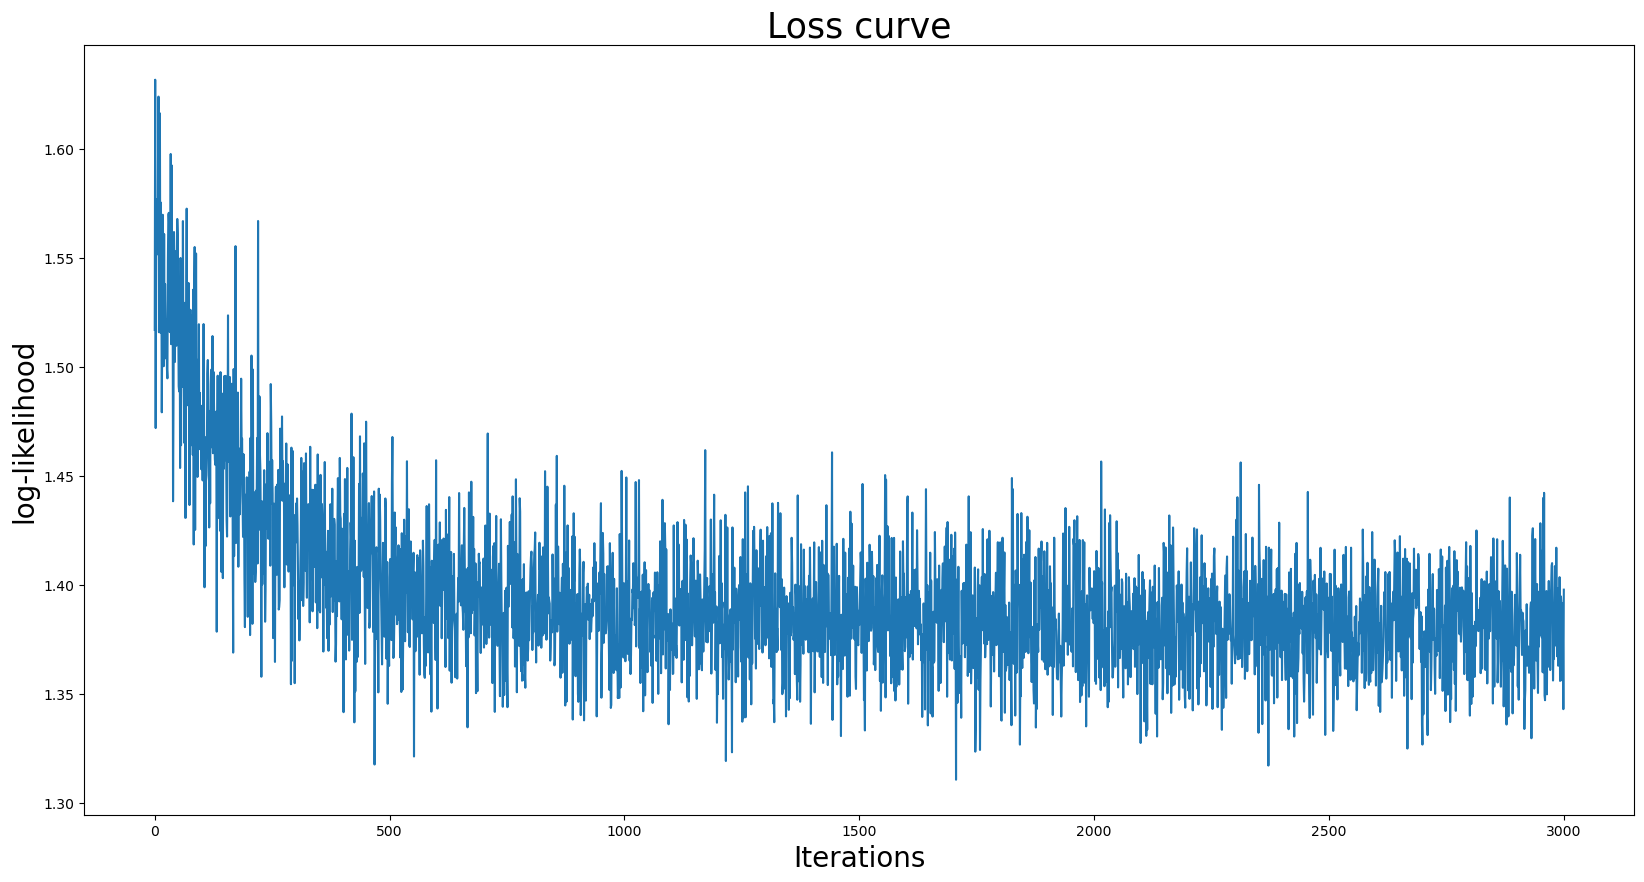

In [10]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('xkcd:white')

plt.plot(loss_visitor.losses)
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("log-likelihood", fontsize=20)
plt.title("Loss curve", fontsize=25)
plt.show()

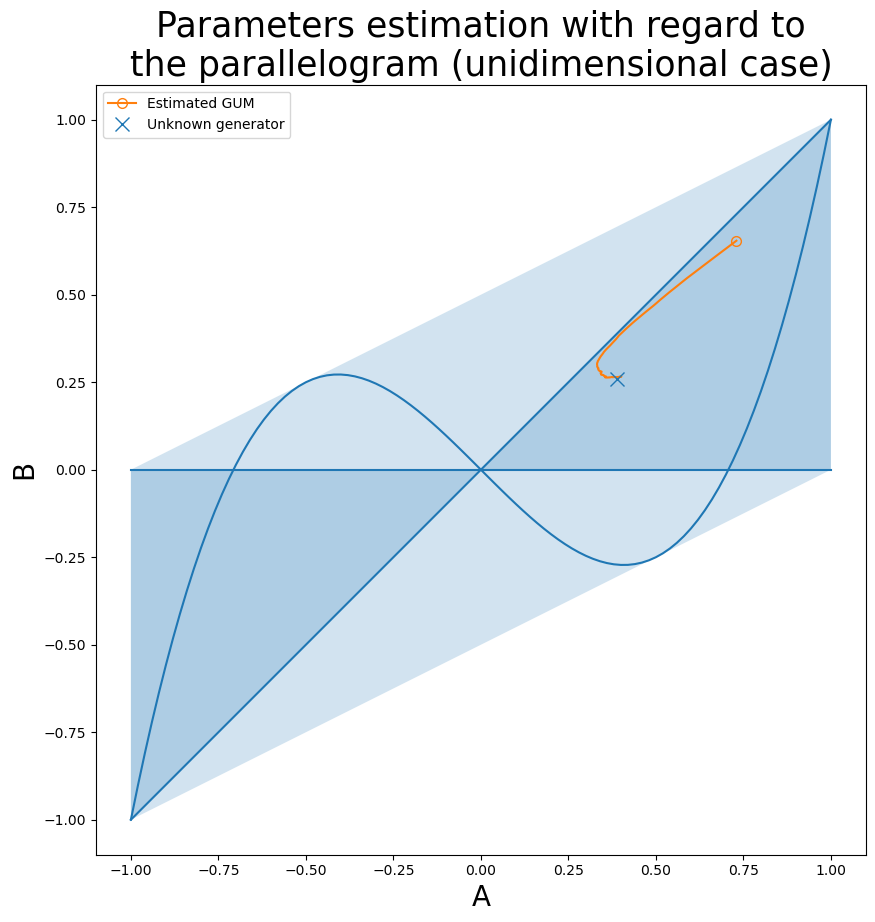

In [11]:
import matplotlib.patches as patches

As = AB_visitor.As
Bs = AB_visitor.Bs

fig = plt.figure(figsize=(10, 10)) 
fig.patch.set_facecolor('xkcd:white')
ax  = fig.add_subplot(111, aspect='equal')

# Parallelogram
x = [-1, -1, 1, 1]
y = [-1,  0, 1, 0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

# HMM
x = [0, 1, 1]
y = [0, 1, 0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

x = [0, -1, -1]
y = [0, -1,  0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

# RNN
def f(a):
    return a * (2 * a**2 - 1)

n = 100
x = [-1 + 2 * (i / n) for i in range(n + 1)]
y = list(map(f, x))
ax.plot(x, y, color = "C0")
ax.plot(x, x, color = "C0")
ax.plot(x, [0 for _ in range(len(x))], color = "C0")


# Results
ax.plot(As, Bs, color="C1")

ax.plot([As[0]], [Bs[0]],
    marker="o", markersize=7, fillstyle="none", label="Estimated GUM", color="C1")

ax.plot(
    [unknown_gum.A.detach().numpy().ravel().ravel()], 
    [unknown_gum.B.detach().numpy().ravel().ravel()],
    marker="x", markersize=10, label="Unknown generator", color="C0", linestyle="None"
)

# Show
ax.legend()
ax.set_xlabel("A", fontsize=20)
ax.set_ylabel("B", fontsize=20)
ax.set_title("Parameters estimation with regard to\nthe parallelogram (unidimensional case)", fontsize=25)
plt.show()